# **1. Project Introduction**

An Indonesian company is interested in evaluating the efficacy of their advertising campaign to measure the extent of its reach and attract potential customers. To achieve this, the company intends to analyze historical advertising data and identify patterns and insights that could inform marketing strategies.

**Goals**:

The primary goals of this endeavor is to develop a machine learning classification model that can accurately identify the appropriate target audience for the advertisement.

**Objectives**:
* **Train classification model**: Train a machine learning model using historical advertising data to classify potential customers accurately, determining the appropriate target audience for the advertisement.
* **Evaluate advertising campaign performance**: Assess the advertising campaign's effectiveness by analyzing key business metrics, including Click-Through Rate (CTR) and Net Profit per Click.
* **Asses model discrimination**: Evaluate the model's ability to discriminate between positive and negative instances by analyzing the Area Under ROC Curve (ROC AUC).
* **Optimize Predictive Probabilities**: Measure the accuracy of the predicted probabilities generated by the model using log loss.

**Business Metric:**
* Click-Through Rate (CTR)
* Net Profit per Click (Revenue per Click (RPC) - Cost per Click (CPC))

**ML Model Metrics:**
* Accuracy Score:  The accuracy score represents the proportion of correctly classified instances among the total instances in the dataset. Higher accuracy scores indicate better overall model performance.
* Area Under ROC Curve : ROC AUC measures the area under the Receiver Operating Characteristic curve, which is useful for binary classification. A higher ROC AUC indicates better model discrimination.
* Loss: Log loss measures the accuracy of the predicted probabilities. Lower log loss is better.

# **2. Notebook Preparation**

In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.2 MB/s eta 0:00:00


In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.8 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
from scipy import stats

# Model Preparation and Modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import random
import optuna
from sklearn.metrics import confusion_matrix
import shap




print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")

Numpy version: 1.23.5
Pandas version: 1.5.3
Seaborn version: 0.12.2


In [5]:
import warnings
warnings.filterwarnings('ignore') ##Be careful in using this code! It makes warning invisible.

In [7]:
df = pd.read_csv("Clicked_Ads_Dataset.csv", sep = ',')

df.sample(5)

,Unnamed: 0,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
91,91,55.79,24,416850350.0,149.67,Perempuan,2/20/2016 20:47,Yes,Bandung,Jawa Barat,Food
243,243,85.03,30,422608480.0,204.52,Perempuan,6/19/2016 9:24,No,Balikpapan,Kalimantan Timur,Otomotif
241,241,53.68,47,393266510.0,115.26,Laki-Laki,2/16/2016 9:11,Yes,Bandung,Jawa Barat,Fashion
386,386,83.49,33,466018000.0,190.75,Laki-Laki,6/3/2016 17:32,No,Tasikmalaya,Jawa Barat,Bank
656,656,85.24,31,NaN,182.84,NaN,6/17/2016 3:23,No,Denpasar,Bali,House


# **3. Exploratory Data Analysis**

## a. Descriptive Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1000 non-null   int64  
 1   Daily Time Spent on Site  987 non-null    float64
 2   Age                       1000 non-null   int64  
 3   Area Income               987 non-null    float64
 4   Daily Internet Usage      989 non-null    float64
 5   Male                      997 non-null    object 
 6   Timestamp                 1000 non-null   object 
 7   Clicked on Ad             1000 non-null   object 
 8   city                      1000 non-null   object 
 9   province                  1000 non-null   object 
 10  category                  1000 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 86.1+ KB


In [9]:
# Drop Unnamed column
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [10]:
df['Male'].unique()

array(['Perempuan', 'Laki-Laki', nan], dtype=object)

In [11]:
# Change male column to gender for clarity
df.rename(columns={'Male': 'gender'}, inplace=True)

In [12]:
df.columns = ['daily_time_spent_on_site', 'age', 'area_income',
              'daily_internet_usage', 'gender', 'timestamp', 'clicked_on_ad', 'city',
              'province', 'category']

In [13]:
# To Transform dataType
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Seperate columns by datatype

# Numical
num_dtypes = ['int64', 'float64']
num_df = df.select_dtypes(include = num_dtypes)
nums = num_df.columns

print(nums)

# Categorical
cat_df = df.select_dtypes(include = 'object')
cats = cat_df.columns

print(cats)

# Datetime
dtime_df = df.select_dtypes(include = 'datetime64[ns]')
dtime = dtime_df.columns

print(dtime)

Index(['daily_time_spent_on_site', 'age', 'area_income',
       'daily_internet_usage'],
      dtype='object')
Index(['gender', 'clicked_on_ad', 'city', 'province', 'category'], dtype='object')
Index(['timestamp'], dtype='object')


In [14]:
df[nums].describe()

,daily_time_spent_on_site,age,area_income,daily_internet_usage
count,987.000000,1000.000000,9.870000e+02,989.000000
mean,64.929524,36.009000,3.848647e+08,179.863620
std,15.844699,8.785562,9.407999e+07,43.870142
min,32.600000,19.000000,9.797550e+07,104.780000
25%,51.270000,29.000000,3.286330e+08,138.710000
50%,68.110000,35.000000,3.990683e+08,182.650000
75%,78.460000,42.000000,4.583554e+08,218.790000
max,91.430000,61.000000,5.563936e+08,267.010000


In [19]:
df['area_income'].nunique()

987

In [16]:
df[cats].describe()

,gender,clicked_on_ad,city,province,category
count,997,1000,1000,1000,1000
unique,2,2,30,16,10
top,Perempuan,No,Surabaya,Daerah Khusus Ibukota Jakarta,Otomotif
freq,518,500,64,253,112


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

daily_time_spent_on_site    13
age                          0
area_income                 13
daily_internet_usage        11
gender                       3
timestamp                    0
clicked_on_ad                0
city                         0
province                     0
category                     0
dtype: int64

1. There is no duplicated data
2. Column with missing values:
  *   daily_time_spent_on_site = 13
  *   area_income = 13
  *   male = 3
  *   daily_internet_usage = 11
3. 'timestamp' column has an unsuitable data type, that is object.  

## b. Univariate Analysis

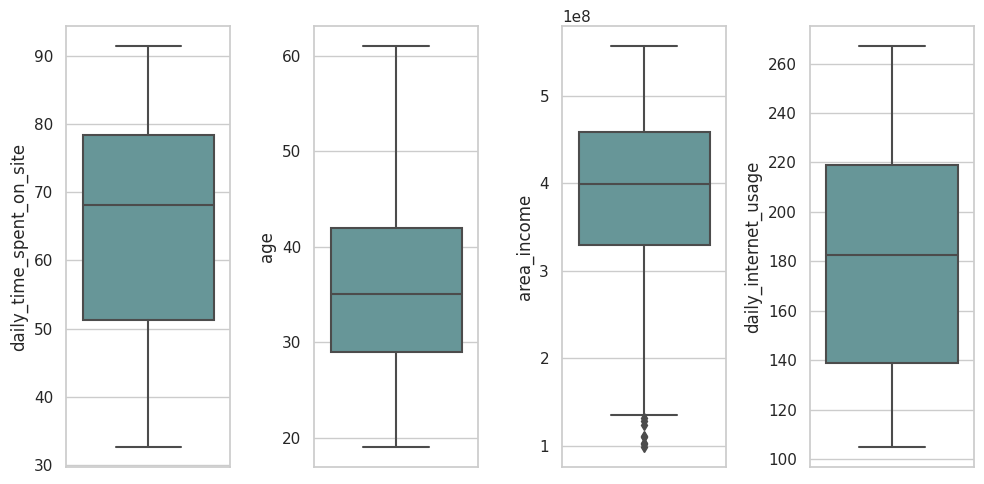

In [ ]:
# Individual BoxpLot
plt.figure(figsize = (10,5))
for i in range(0, len(nums)):
  plt.subplot(1, 4, i+1)
  sns.boxplot(y = df[nums[i]], color = '#5F9EA0', orient = 'v')
  plt.tight_layout()

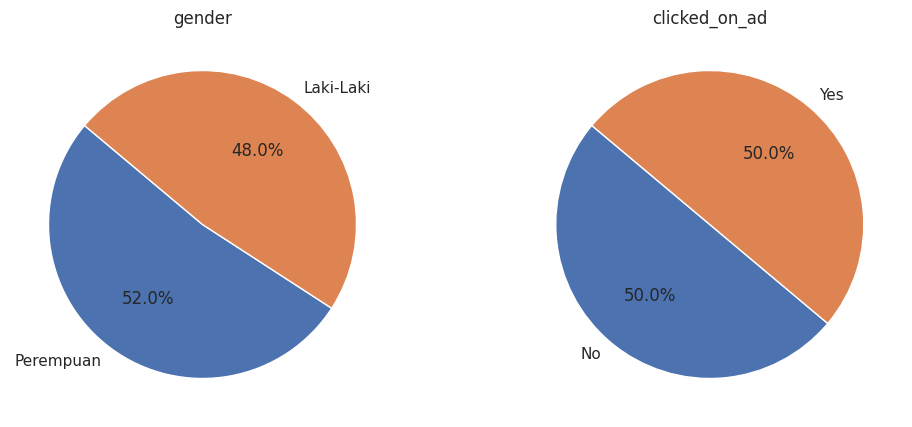

In [ ]:
# Pie plot for gender and target label
# Define columns
pie_cols = ['gender', 'clicked_on_ad']

# Plot
plt.figure(figsize=(12, 5))

for i, col in enumerate(pie_cols, 1):
    plt.subplot(1, 2, i)
    plt.title(f'{col}')
    plt.pie(df[col].value_counts(), labels=df[col].value_counts().index, autopct='%1.1f%%', startangle=140)

plt.show()

The target label, **'clicked_on_ad,'** is already balanced, eliminating the need to address class imbalance later on.

Furthermore, the gender distribution in this dataset is also balanced.

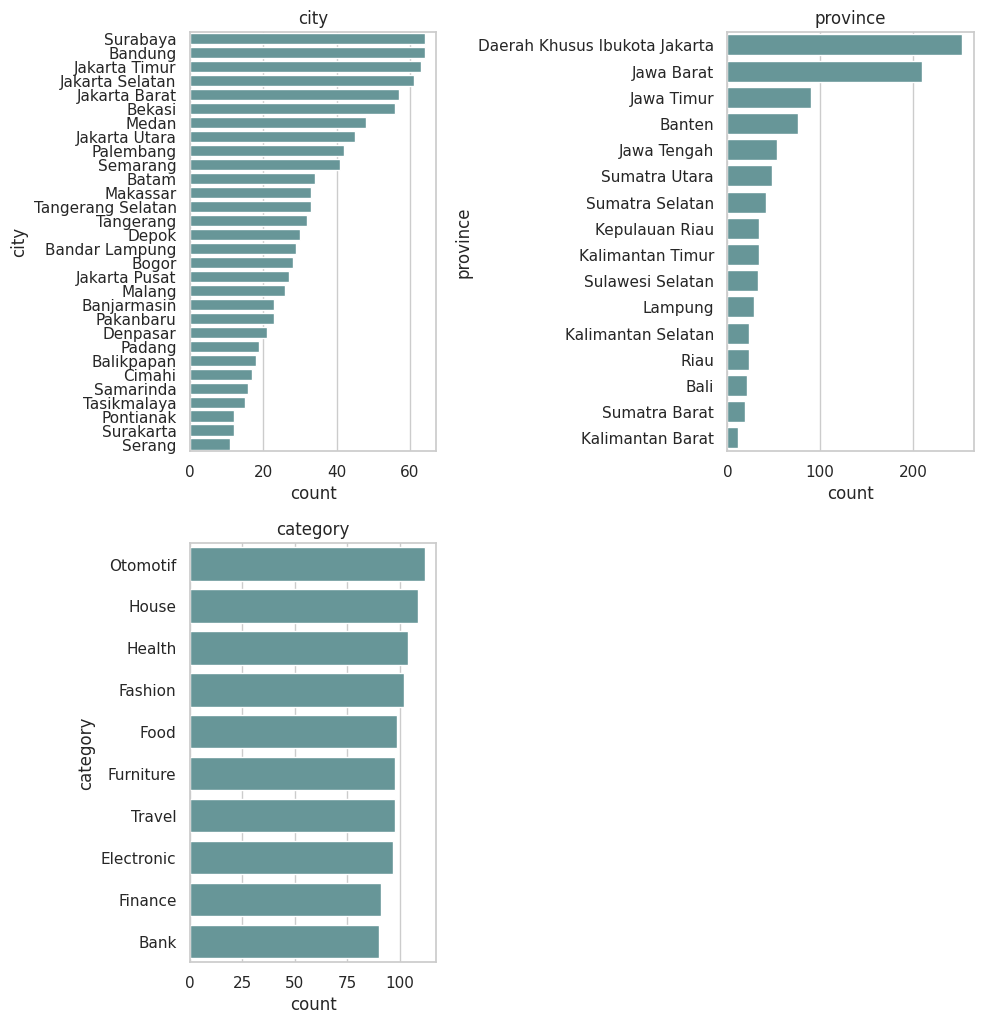

In [ ]:
# Individual Countplot for the rest of category columns
# Define columns to plot
col_plot = cats[2:]

plt.figure(figsize = (10,15))
for i, col in enumerate(col_plot, 1):
    plt.subplot(3, 2, i)
    sns.countplot(y=df[col], color='#5F9EA0', orient='h', order=df[col].value_counts().index)
    plt.title(f'{col}')
    plt.tight_layout()

plt.show()


DKI Jakarta and West Java emerge as the predominant provinces in the dataset. However, East Java, ranking third, exhibits 'Surabaya' as its primary contributor to ad clicks, closely followed by Bandung and East Jakarta. Furthermore, the distribution of product categories appears to be balanced.

# **4. Data Cleaning**

To enhance the precision of our multivariate analysis, we will first address missing values and outliers in the dataset. Additionally, we'll encode the target variable to prepare the data for a more robust analysis.

## Target Feature Encoding

In [ ]:
# Label encode the target variable

mapping_click = {'No' : 0,
                 'Yes' : 1}

df['clicked_on_ad'] = df['clicked_on_ad'].map(mapping_click)

df['clicked_on_ad'].value_counts()

0    500
1    500
Name: clicked_on_ad, dtype: int64

## Handling Missing Values

In [ ]:
miss = ['daily_time_spent_on_site', 'area_income', 'daily_internet_usage', 'gender']

for x in miss:
  print(f"There's {df[x].isna().sum()} rows with missing value in '{x}' column. That is {round((df[x].isna().sum()/len(df))*100,3)}% of entire data")

There's 13 rows with missing value in 'daily_time_spent_on_site' column. That is 1.3% of entire data
There's 13 rows with missing value in 'area_income' column. That is 1.3% of entire data
There's 11 rows with missing value in 'daily_internet_usage' column. That is 1.1% of entire data
There's 3 rows with missing value in 'gender' column. That is 0.3% of entire data


Imputation will be performed for all missing values except in the gender column. The missing values in gender column will be drop.

In [ ]:
imp = ['daily_time_spent_on_site', 'area_income', 'daily_internet_usage']

for x in imp:
  df[x] = df[x].fillna(df[x].median())

In [ ]:
df = df.dropna(subset=['gender'])

## Timestamp Feature Extraction

Let's extract the timestamp column first

In [ ]:
df_clean = df.copy()

df_clean['timestamp'].sample(2)

166   2016-01-10 23:14:00
9     2016-07-11 01:42:00
Name: timestamp, dtype: datetime64[ns]

In [ ]:
# Extract the year, month, week, and day from timestamp column
df_clean['year'] = df_clean['timestamp'].dt.year
df_clean['month'] = df_clean['timestamp'].dt.month_name()
df_clean['week'] = df_clean['timestamp'].dt.week
df_clean['day'] = df_clean['timestamp'].dt.day

# Extract the day of the week
df_clean['day_of_week'] = df_clean['timestamp'].dt.day_name()

# Extract the hour of the day
df_clean['hour_of_day'] = df_clean['timestamp'].dt.hour

df_clean.columns

Index(['daily_time_spent_on_site', 'age', 'area_income',
       'daily_internet_usage', 'gender', 'timestamp', 'clicked_on_ad', 'city',
       'province', 'category', 'year', 'month', 'week', 'day', 'day_of_week',
       'hour_of_day'],
      dtype='object')

In [ ]:
# Check every unique values in the new columns

col = ['year', 'month', 'week', 'day', 'day_of_week', 'hour_of_day']

for i in range(len(col)):
  print(f"{col[i]}: {df_clean[col[i]].unique()}")


year: [2016]
month: ['March' 'April' 'January' 'June' 'May' 'July' 'February']
week: [12 14 10  1 22 20  4 16 28 11 18  6  8 24 21 29 15 26  9  2 17  7 23 13
  5 27 19 25 53  3]
day: [27  4 13 10  3 19 28  7 18 11 16  8 20 24  9 30  2  5 23 14  1 15 12 17
 26 25 31 22  6 21 29]
day_of_week: ['Sunday' 'Monday' 'Friday' 'Thursday' 'Wednesday' 'Saturday' 'Tuesday']
hour_of_day: [ 0  1 20  2  3 14  9  8 21 19  7  4 13 17 15 10  5 12 22  6 11 18 23 16]


Given that the dataset appears to encompass only a single year, we can streamline our analysis by removing the year column.

In [ ]:
# Drop timestamp and year columns

col_to_drop = ['timestamp', 'year']

df_clean = df_clean.drop(col_to_drop, axis=1)

df_clean.sample(2)

,daily_time_spent_on_site,age,area_income,daily_internet_usage,gender,clicked_on_ad,city,province,category,month,week,day,day_of_week,hour_of_day
415,41.18,43,293065850.0,129.25,Laki-Laki,1,Medan,Sumatra Utara,Finance,July,27,5,Tuesday,0
39,68.11,39,192558870.0,162.08,Perempuan,1,Cimahi,Jawa Barat,Travel,March,10,11,Friday,6


## Handling Outliers

In [ ]:
nums = ['daily_time_spent_on_site', 'age', 'area_income',
       'daily_internet_usage', 'week', 'day', 'hour_of_day']

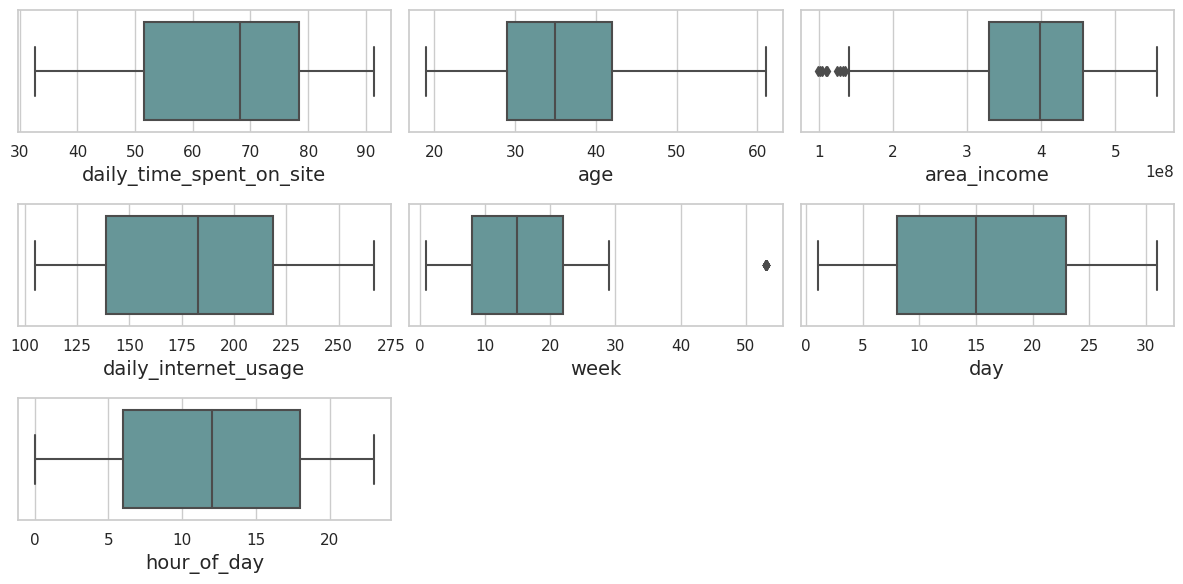

In [ ]:
plt.figure(figsize=(12,6))
for i in range(0, len(nums)):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df_clean[nums[i]], color='#5F9EA0', orient='v')
    plt.xlabel(nums[i], fontsize=14)
    plt.tight_layout()

A pronounced outlier is evident in the week column, prompting us to investigate whether it results from a potential imputation error.

Moreover, there are outliers observed in the area income values. Nevertheless, we plan to address normalization at a later stage since the outliers are not significantly distant.

In [ ]:
outlier = df_clean.copy()

# Check what week is the outlier
outlier_week = outlier[outlier['week'] > 40]
outlier_week['week'].value_counts()

53    19
Name: week, dtype: int64

All of the week is in week 53. Let's do further investigation.

In [ ]:
# Check the month that have the week 53
outlier_month = outlier[outlier['week'] == 53]
outlier_month['month'].value_counts()

January    19
Name: month, dtype: int64

In [ ]:
jan = outlier[outlier['month'] == 'January']

jan['week'].value_counts()

1     40
4     33
2     32
3     23
53    19
Name: week, dtype: int64

In the ISO week date system, the first week of the year includes the days up to the first Thursday, ensuring it has at least four days in the new year. As a result, the initial days of January can fall into the last week of the previous year, denoted as week 53. Therefore, the presence of week 53 is not an imputation error. To maintain consistency with the Gregorian calendar for further analysis, we will reassign this week to week 1.

In [ ]:
# Reassign week 53 to week 1
df_clean.loc[(df_clean['week'] == 53) & (df_clean['month'] == 'January'), 'week'] = 1

df_clean['week'].max()

29

In [ ]:
# Check Data Skewness
df_clean.skew()

daily_time_spent_on_site   -0.378935
age                         0.477324
area_income                -0.655265
daily_internet_usage       -0.034741
clicked_on_ad              -0.002009
week                        0.058748
day                         0.047465
hour_of_day                 0.001133
dtype: float64

The skewness in the data are not severe and therefore we can go on and do data normalization later on.

# **5. Bivariate Analysis**

In [ ]:
yes = df_clean[df_clean['clicked_on_ad'] == 1]
no = df_clean[df_clean['clicked_on_ad'] == 0]

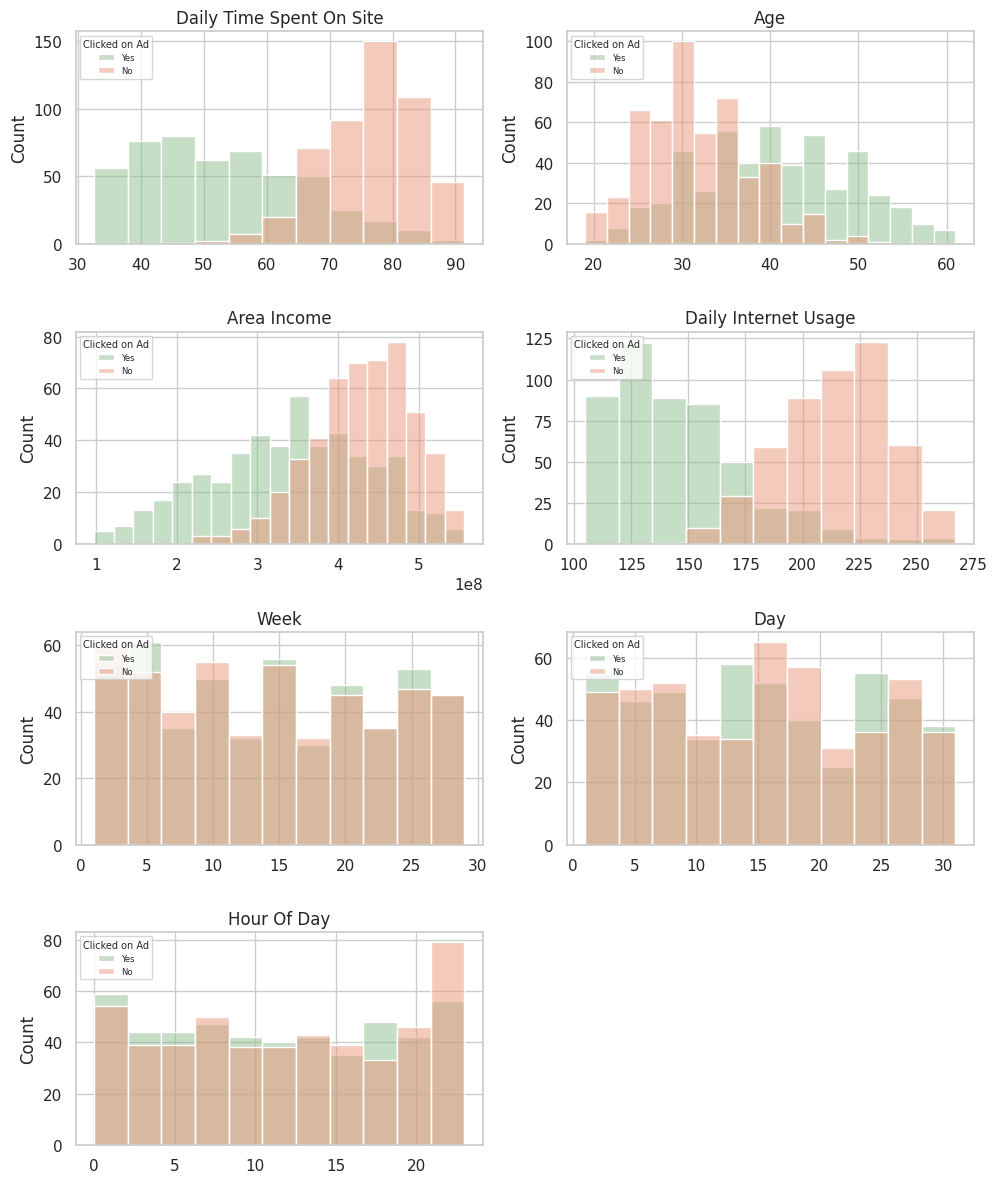

In [ ]:
# Set up the subplot grid
num_features = len(nums)
num_rows = (num_features + 1) // 2
num_cols = 2

# Initialize the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i in range(num_features):
    # Use i-th subplot
    sns.histplot(data=df_clean, x=nums[i], hue='clicked_on_ad', palette=['#E9967A', '#8FBC8F'], ax=axs[i])
    axs[i].set_title(nums[i].replace('_', ' ').title(), fontsize=12)
    axs[i].set_xlabel('')
    axs[i].legend(title='Clicked on Ad', labels=['Yes', 'No'], title_fontsize='7', fontsize='6', loc='upper left')

# Remove empty subplot if the number of features is odd
if num_features % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

Customer who clicked on ad distributed well across the

Customers who **clicked on the ad** typically spent the majority of their **daily time on the site** within the **30 to 70 minutes** range. In contrast, those who did **not click on the ad** tended to spend a larger portion of their time, ranging from **above 60 to 90** minutes on the site.

The **ages** of customers who **clicked on the ad** are **evenly distributed** across the dataset. Meanwhile, customers who **did not click on the ad** are mainly between the ages of **20 and 40**.

The distribution of **income areas** among customers who **clicked on the ad** is **uniform** across the dataset. Conversely, customers who **did not click on the ad** predominantly belong to **higher-income areas**.

Customers who **clicked on the ad** generally exhibited a **daily internet usage** ranging from **100 to 180 megabytes**. Conversely, customers who **did not click on the ad** predominantly utilized between **180 to 250 megabytes** each day.

The distributions of **week, date, and hour of the day** seems **equally distributed** between those who **clicked on the ad or not**.

Let's analyze the hours when customers are more likely to either click or ignore the ad.

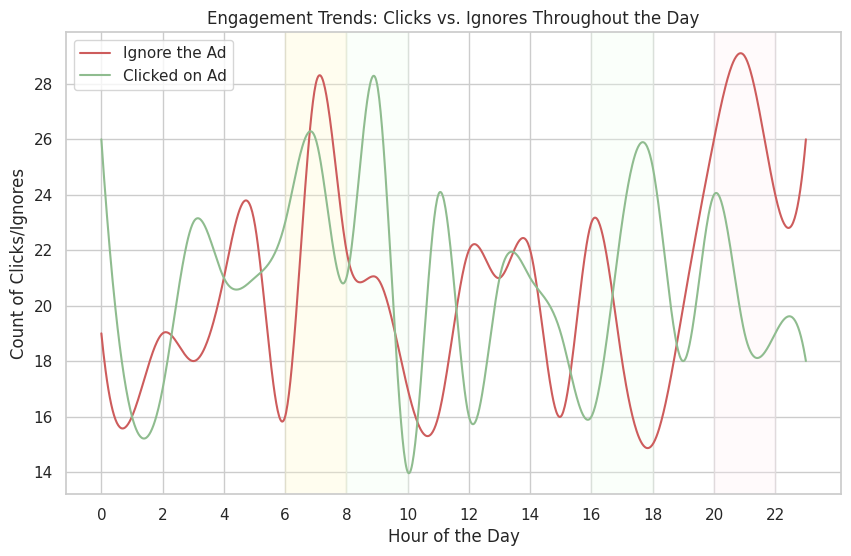

In [ ]:
from scipy.interpolate import interp1d

sns.set(style="whitegrid")

# Create a DataFrame to store the aggregated counts for each hour and 'clicked_on_ad'
agg_df_hour = df_clean.groupby(['hour_of_day', 'clicked_on_ad']).size().reset_index(name='count')

# Create spline interpolation function for 'clicked_on_ad' groups
clicked_on_ad_values_hour = agg_df_hour['clicked_on_ad'].unique()
spline_dict_hour = {}

# Increase the number of points for interpolation
x_values_hour = np.linspace(0, 23, 1000)

for value in clicked_on_ad_values_hour:
    subset_hour = agg_df_hour[agg_df_hour['clicked_on_ad'] == value].sort_values('hour_of_day')
    spline_dict_hour[value] = interp1d(subset_hour['hour_of_day'], subset_hour['count'], kind='cubic', fill_value="extrapolate")

# Plot the spline curves with more points and custom colors
plt.figure(figsize=(10, 6))

for value in clicked_on_ad_values_hour:
    label = 'Clicked on Ad' if value == 1 else 'Ignore the Ad'
    color = '#8FBC8F' if value == 1 else '#CD5C5C'
    plt.plot(x_values_hour, spline_dict_hour[value](x_values_hour), label=label, color=color)

# Customize x-axis ticks to represent the hours of the day
plt.xticks(np.arange(0, 24, 2))

# Emphasize the range on the x-axis
plt.axvspan(6, 8, color='#FFFACD', alpha=0.3)
plt.axvspan(8, 10, color='#F0FFF0', alpha=0.3)
plt.axvspan(16, 18, color='#F0FFF0', alpha=0.3)
plt.axvspan(20, 22, color='#FFF0F5', alpha=0.3)

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Clicks/Ignores')
plt.title('Engagement Trends: Clicks vs. Ignores Throughout the Day')

# Add legend with adjusted labels
plt.legend()

# Show the plot
plt.show()

In the early morning hours, from 6 to 8 am, we observe a dual surge in engagement with the ad. While a significant portion of individuals tends to overlook the ad during this timeframe, an intriguing secondary peak emerges, indicating a noteworthy group actively clicking. As the morning progresses, the main peak in ad clicks becomes more apparent, particularly between 8 and 10 am, accompanied by a resurgence during the initial hours of 6 to 8 am, and another noticeable surge from 4 to 6 pm. As the night unfolds, a prevalent trend emerges where the majority tend to ignore the ad, especially between 8 to 10 pm. However, a captivating resurgence of ad-clicking enthusiasts emerges at midnight, only to gradually taper off again by 2 am.

In [ ]:
df_clean.columns

Index(['daily_time_spent_on_site', 'age', 'area_income',
       'daily_internet_usage', 'gender', 'clicked_on_ad', 'city', 'province',
       'category', 'month', 'week', 'day', 'day_of_week', 'hour_of_day'],
      dtype='object')

In [ ]:
cats = ['gender', 'month', 'day_of_week', 'city', 'province', 'category']

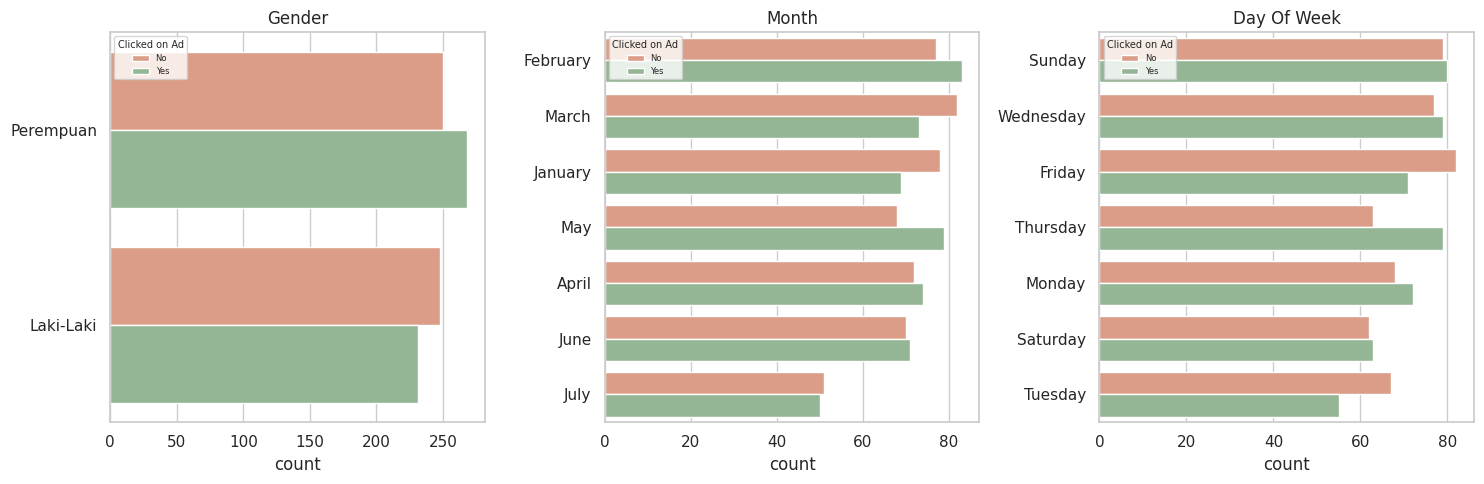

In [ ]:
selected_col = ['gender', 'month', 'day_of_week']

# Set up the subplot grid
num_columns = len(selected_col)
num_rows = 1
num_cols = num_columns

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through columns and create horizontal bar plots
for i, column in enumerate(selected_col):
    # Sort the data by count
    sorted_data = df_clean[column].value_counts().sort_values(ascending=False).index

    sns.countplot(y=column, data=df_clean, order=sorted_data, hue='clicked_on_ad', ax=axs[i], palette=['#E9967A', '#8FBC8F'])
    axs[i].set_title(selected_col[i].replace('_', ' ').title(), fontsize=12)
    axs[i].set_ylabel('')
    axs[i].legend(title='Clicked on Ad', labels=['No', 'Yes'], title_fontsize='7', fontsize='6', loc='upper left')
    axs[i].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

The inclination to click on ads is slightly higher among females than males. The month of February sees the highest ad exposure, consequently leading to a surge in ad clicks, followed by May and April. Conversely, interest in the ads dwindles during March, with January and February also showing a decline in engagement.

Ads were predominantly received on Sundays, with slightly over half of the recipients clicking on them. Wednesdays saw a similar trend, with slightly more clicks than ignores. Thursdays stood out as the day with the highest click rate. On the other hand, Fridays had the highest count of people choosing to ignore the ads.

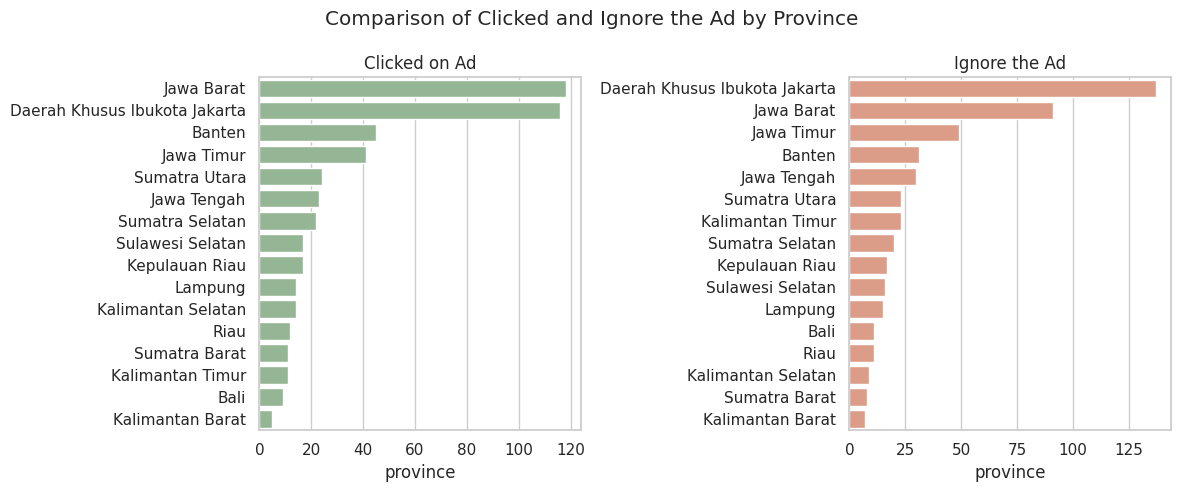

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12,5))

sns.barplot(x=yes['province'].value_counts(), y=yes['province'].value_counts().index, ax=axs[0], color="#8FBC8F")
axs[0].set_title('Clicked on Ad')

sns.barplot(x=no['province'].value_counts(), y=no['province'].value_counts().index, ax=axs[1], color="#E9967A")
axs[1].set_title('Ignore the Ad')

plt.suptitle('Comparison of Clicked and Ignore the Ad by Province')
plt.tight_layout()
plt.show()

The majority of individuals from West Java and DKI Jakarta exhibit a significant inclination towards clicking on the ad. In contrast, for those who ignore the ad, people from Jakarta constitute the majority, followed by a substantial decrease in engagement from West Java. It can be inferred that if the number of individuals from Jakarta and West Java were equal, there is a high likelihood that a significant portion of those from West Java would click on the ad.

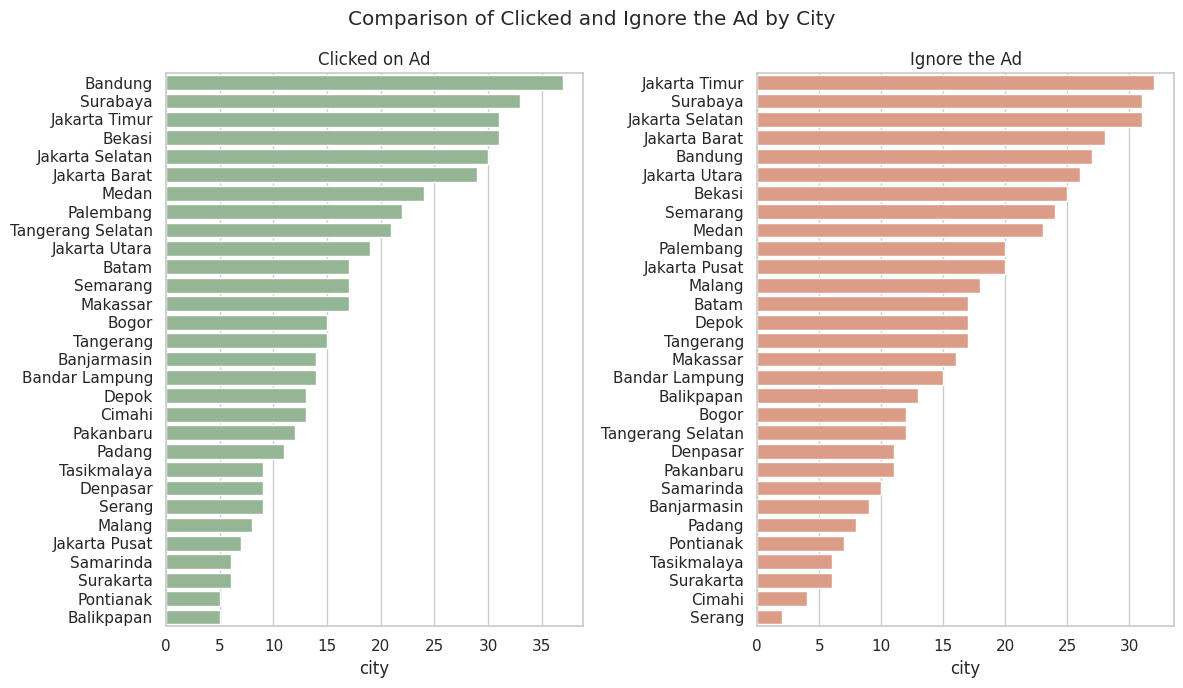

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 7))

sns.barplot(x=yes['city'].value_counts(), y=yes['city'].value_counts().index, ax=axs[0], color="#8FBC8F")
axs[0].set_title('Clicked on Ad')

sns.barplot(x=no['city'].value_counts(), y=no['city'].value_counts().index, ax=axs[1], color="#E9967A")
axs[1].set_title('Ignore the Ad')

plt.suptitle('Comparison of Clicked and Ignore the Ad by City')
plt.tight_layout()
plt.show()


Our assertion that individuals from West Java are more likely to click on the ad than those from Jakarta is substantiated in the province plot. Notably, in West Java's largest city, Bandung, the majority of ad clicks are observed, while Bandung ranks fifth among places where people tend to ignore the ad.

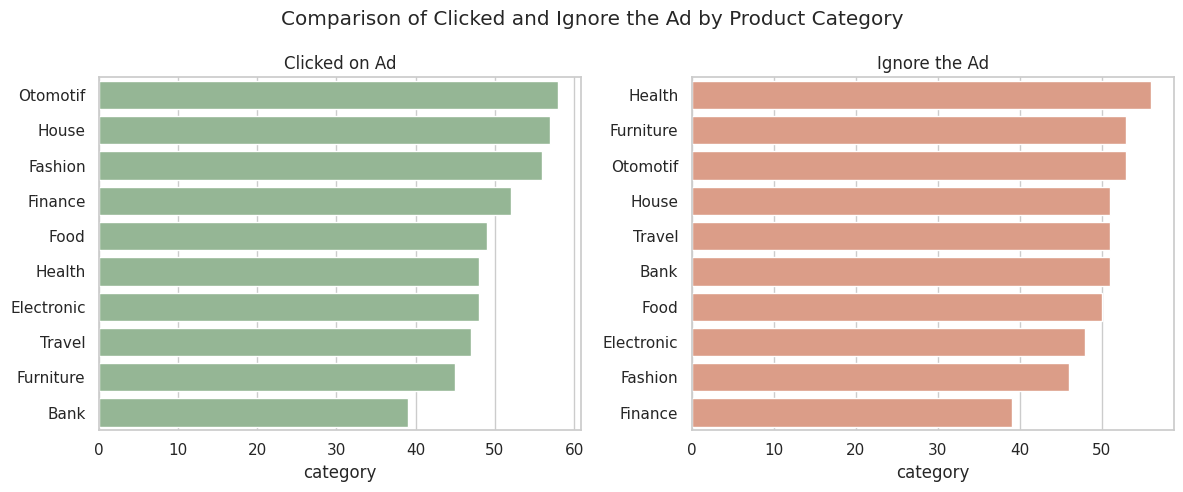

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=yes['category'].value_counts(), y=yes['category'].value_counts().index, ax=axs[0], color="#8FBC8F")
axs[0].set_title('Clicked on Ad')

sns.barplot(x=no['category'].value_counts(), y=no['category'].value_counts().index, ax=axs[1], color="#E9967A")
axs[1].set_title('Ignore the Ad')

plt.suptitle('Comparison of Clicked and Ignore the Ad by Product Category')
plt.tight_layout()
plt.show()

People tend to more interested in seeing ads about automotives, house, and fashion rather than health and furniture.

# **6. Multivariate Analysis**

<Figure size 1200x800 with 0 Axes>

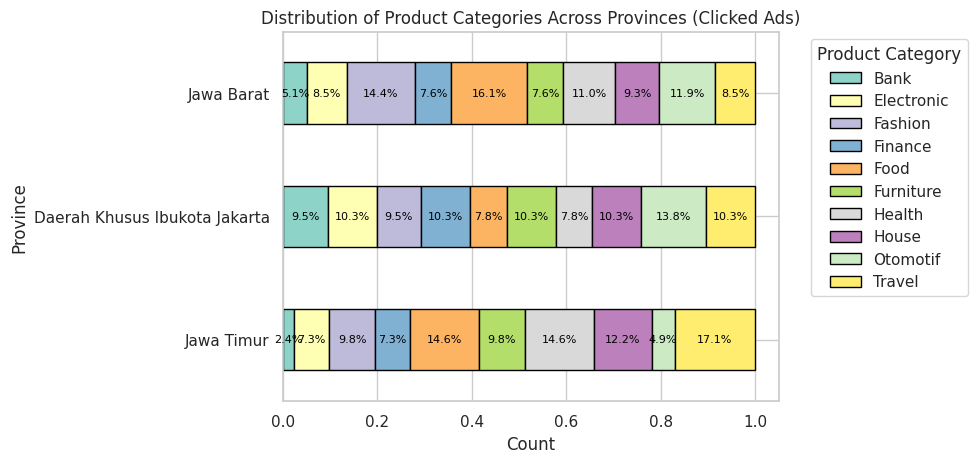

In [ ]:
# Distribution the clicked ad of product category in DKI Jakarta, West Java, and Banten (provinces with major ad clicks)
yes2 = yes[['province', 'category']]
# Filter the DataFrame for specific provinces
selected_provinces = ['Daerah Khusus Ibukota Jakarta', 'Jawa Barat', 'Jawa Timur']
yes2 = yes2[yes2['province'].isin(selected_provinces)]

# Create a pivot table for stacking
pivot_table = yes2.pivot_table(index='province', columns='category', aggfunc=len, fill_value=0)

# Calculate the overall count for each province
overall_count = pivot_table.sum(axis=1)

# Sort the provinces based on overall count
sorted_provinces = overall_count.sort_values(ascending=True).index
pivot_table = pivot_table.loc[sorted_provinces]

# Create a stacked bar plot
plt.figure(figsize=(12, 8))
ax = pivot_table.div(pivot_table.sum(axis=1), axis=0).plot(kind='barh', stacked=True, colormap='Set3', edgecolor='black')

# Add percentage labels on each bar
for p in ax.patches:
    width = p.get_width()
    label_x = p.get_x() + width / 2
    label_y = p.get_y() + p.get_height() / 2
    percentage = f'{width*100:.1f}%'
    ax.text(label_x, label_y, percentage, ha='center', va='center', color='black', fontsize=8)

plt.title('Distribution of Product Categories Across Provinces (Clicked Ads)')
plt.xlabel('Count')
plt.ylabel('Province')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

It's clear that the main contributors to clicked ads from West Java have a strong inclination towards interests in food, fashion, and automotives. In contrast, contributors from DKI Jakarta demonstrate a pronounced interest in automotives, along with a significant engagement in electronics, finance, furniture, and household products at similar percentages. Additionally, contributors from East Java show a heightened interest in ads related to travel, with health and food following closely at equivalent percentages.

## Correlation Between Numerical Features

Pearson's correlation is used to measure the linear relationship between two numerical variables. It provides a coefficient that quantifies the strength and direction of this linear association, making it suitable for assessing the degree of linear correlation between variables.


H0: Features does not have correlation with one another
Ha: Features have correlation with one another


We can see whether the features have correlation with one another by seeing the correlation score.

Correlation Score Threshold:

* Strong Positive Correlation: Above 0.7
* Moderate Positive Correlation: 0.3 to 0.7
* Weak Positive Correlation: 0.1 to 0.3
* No Linear Correlation: Around 0
* Weak Negative Correlation: -0.1 to -0.3
* Moderate Negative Correlation: -0.3 to -0.7
* Strong Negative Correlation: Below -0.7

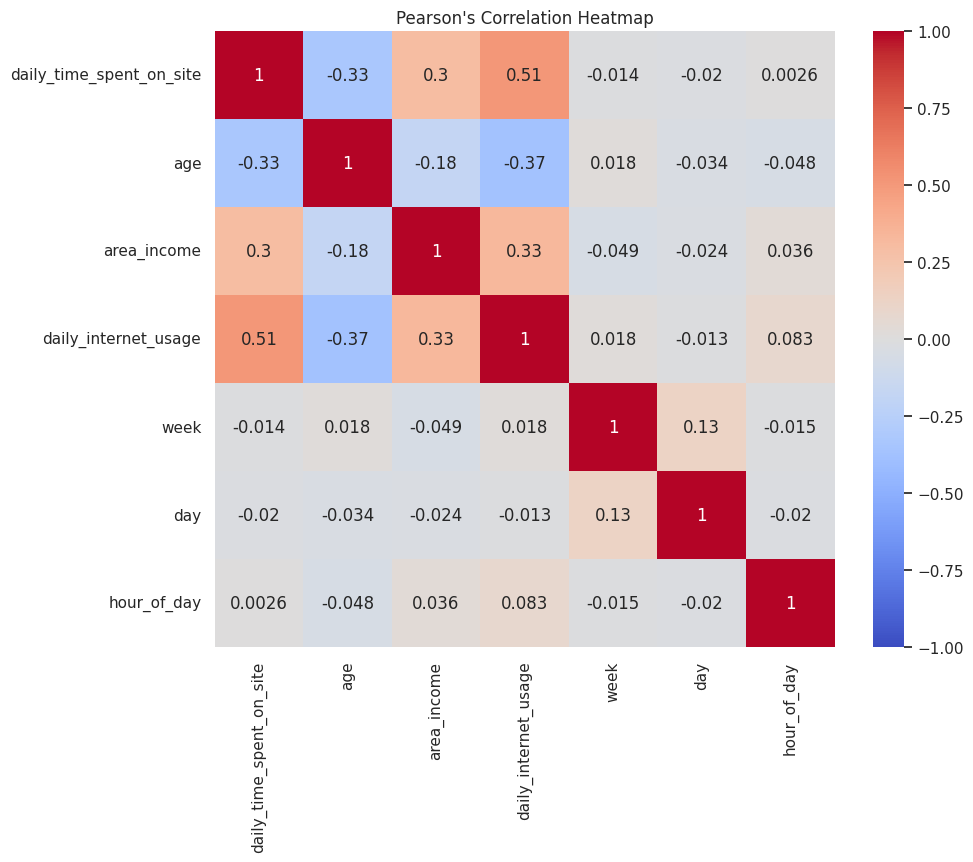

In [ ]:
# Calculate correlation matrix between numercal features
corr = df_clean[nums].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, vmin = -1, vmax = 1, annot=True, cmap='coolwarm', annot_kws={"size": 12})
plt.title("Pearson's Correlation Heatmap")
plt.show()

Most of the numerical features are low correlated with one another except for 'daily_inter_usage' and 'daily_time_spent_on_site' that shows a moderate correlation. This is quite good as we want to avoid multicollinearity in making our machine learning model.

## Between Categorical and Binary Features

The chi-squared test of independence is used to assess whether there is a significant association or dependence between two categorical variables, which includes testing the relationship between categorical and binary variables. It determines if the observed frequencies in a contingency table deviate significantly from what would be expected if the variables were independent. This test helps evaluate if changes in one variable are related to changes in the other, making it a suitable method for analyzing the correlation or association between categorical and binary variables.


* H0: Features does not have correlation with one another
* Ha: Features have correlation with one another


We can see whether the features have correlation with one another by seeing the P-Value.

α = 0.05

If:

* P-Value < α: H0 is rejected
* P-Value > α: H0 is accepted

In [ ]:
binary = ['clicked_on_ad', 'gender']

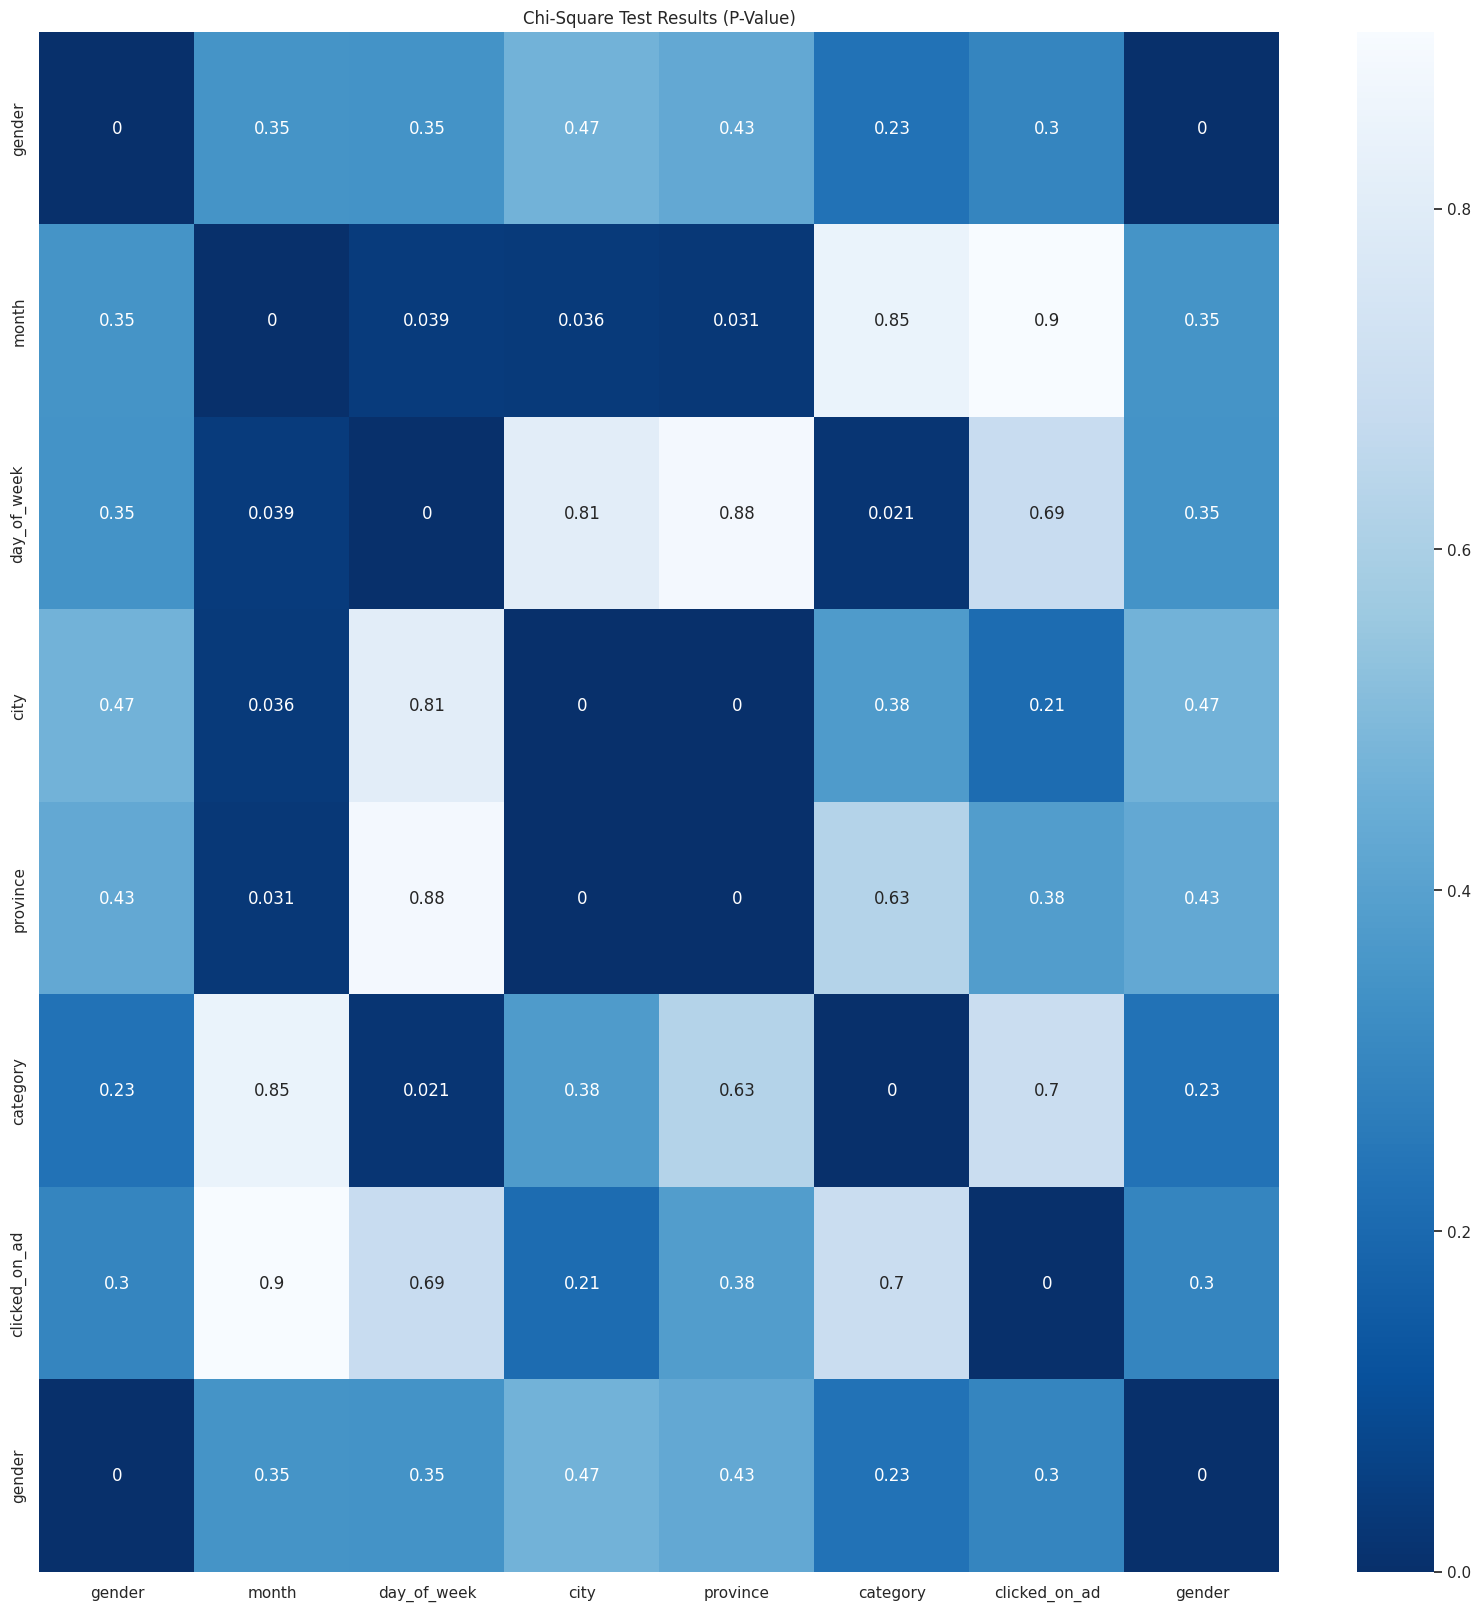

In [ ]:
from scipy.stats import chi2_contingency

# Define selected_columns
selected_columns = cats + binary

# Initialize the result matrix
result = pd.DataFrame(data=0, columns=selected_columns, index=selected_columns)

# Finding p-value for all columns and putting them in the result matrix
for i in selected_columns:
    for j in selected_columns:
        if i != j:
            contingency_table = pd.crosstab(df_clean[i], df_clean[j])
            chi2_val, p_val, _, _ = chi2_contingency(contingency_table)
            result.loc[i, j] = p_val

# Plotting a heatmap
fig = plt.figure(figsize=(20, 20))
sns.heatmap(result, annot=True, cmap='Blues_r')
plt.title('Chi-Square Test Results (P-Value)')
plt.show()

The categorical features does not have a relationship with the target features.

## Between Numerical and Categorical Features

ANOVA (Analysis of Variance) is used to test the differences in means among multiple groups or categories. It is employed to assess if there are significant variations in a numerical variable across different categories within a categorical variable. In this context, ANOVA helps test the correlation or association between numerical and categorical variables.

* H0: Features does not have correlation with one another
* Ha: Features have correlation with one another

We can see whether the features have correlation with one another by seeing the P-Value.

α = 0.05

If:

* P-Value < α: H0 is rejected
* P-Value > α: H0 is accepted

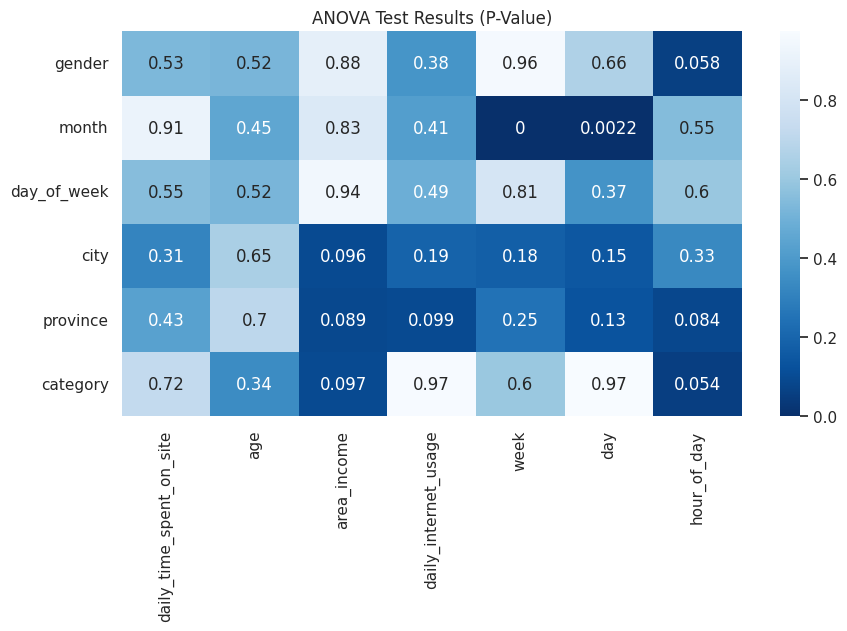

In [ ]:
from scipy.stats import f_oneway
import seaborn as sns

numeric_features = nums
anova_results = {}

# Create an empty DataFrame to store the p-values
p_values_df = pd.DataFrame(index=cats, columns=numeric_features, dtype=np.float64)

# Loop through each numerical feature
for num_feat in numeric_features:
    groups = []

    # Nested loop through each categorical feature
    for cat_feat in cats:
        # Create a list of group data for each category in the categorical feature
        group_data = [df_clean[num_feat][df_clean[cat_feat] == category] for category in df_clean[cat_feat].unique()]

        # Perform one-way ANOVA and store the result
        F, p = f_oneway(*group_data)

        # Store the p-value in the DataFrame
        p_values_df.loc[cat_feat, num_feat] = p

# Plot the p-values as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(p_values_df.astype(float), cmap='Blues_r', annot=True)
plt.title('ANOVA Test Results (P-Value)')
plt.show()

Only day and month features that have correlation with one another.

## Between Numerical and Binary Features (Including Target)

The point-biserial test is used to assess the correlation between a numerical variable and a binary (dichotomous) variable. It quantifies the strength and direction of the relationship between a continuous numerical variable and a binary outcome variable, making it suitable for analyzing the correlation between numerical and binary variables.


H0: Features does not have correlation with one another

Ha: Features have correlation with one another


We can see whether the features have correlation with one another by seeing the correlation score.

Correlation Score Threshold:

* Strong Positive Correlation: Above 0.7
* Moderate Positive Correlation: 0.3 to 0.7
* Weak Positive Correlation: 0.1 to 0.3
* No Linear Correlation: Around 0
* Weak Negative Correlation: -0.1 to -0.3
* Moderate Negative Correlation: -0.3 to -0.7
* Strong Negative Correlation: Below -0.7

We're going to do a label encoding first because point-biserial test need both features to be in numerical type.

In [ ]:
df_clean['gender'].unique()

array(['Perempuan', 'Laki-Laki'], dtype=object)

In [ ]:
# Label Encode 'gender'
# Create a mapping dictionary
gender_mapping = {'Laki-Laki': 1, 'Perempuan': 0}

# Apply mapping to create a new column 'is_male'
df_clean['is_male'] = df_clean['gender'].map(gender_mapping)

# Drop the original 'gender' column if needed
df_clean = df_clean.drop('gender', axis=1)

# Display the DataFrame
df_clean['is_male'].sample(2)

941    0
495    0
Name: is_male, dtype: int64

In [ ]:
binary = ['clicked_on_ad', 'is_male']

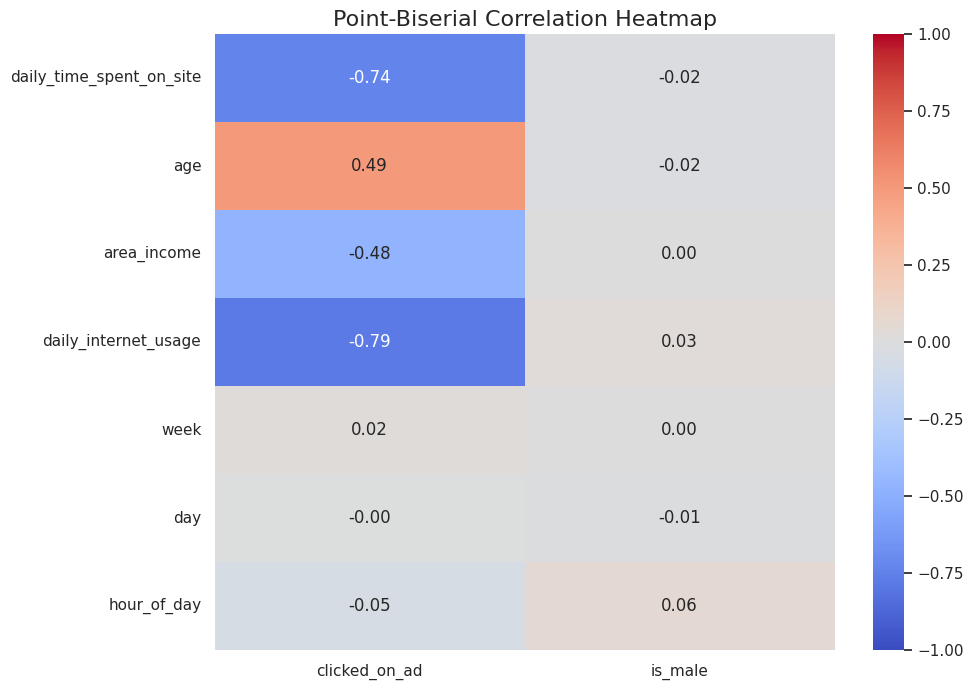

In [ ]:
# Import the necessary library
from scipy.stats import pointbiserialr

# Apply point-biserial correlation on each pair of features in the selected features
correlations = pd.DataFrame(index=binary, columns=nums)

for i in binary:
    for j in nums:
        if i != j:
            correlations.loc[i, j] = pointbiserialr(df_clean[i], df_clean[j])[0]

# Transpose the correlations DataFrame to switch the axes
correlations = correlations.T

# Visualize the correlations through a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations.astype(float), annot=True,  vmin = -1, vmax = 1, cmap="coolwarm", fmt=".2f")
plt.title("Point-Biserial Correlation Heatmap", fontsize=16)
plt.show()

There is no correlation between the numerical features and the gender feature. Notably, 'daily_time_spent_on_site' and 'daily_internet_usage' exhibit a strong negative correlation, while 'age' displays a moderate positive correlation, and 'area_income' demonstrates a moderate positive correlation with the target feature.

In [ ]:
df_clean.columns

Index(['daily_time_spent_on_site', 'age', 'area_income',
       'daily_internet_usage', 'clicked_on_ad', 'city', 'province', 'category',
       'month', 'week', 'day', 'day_of_week', 'hour_of_day', 'is_male'],
      dtype='object')

## Further Analysis

Now we know that only 'daily_time_spent_on_site', 'age', 'area_income', and 'daily_internet_usage' that have a moderate to high correlation with 'clicked_on_ad'. We will do further analysis only for this features to get more insights.

In [ ]:
# Select features to do further analysis with
selected_feat = ['daily_time_spent_on_site', 'age', 'area_income',
                 'daily_internet_usage', 'clicked_on_ad']

<Figure size 1200x1000 with 0 Axes>

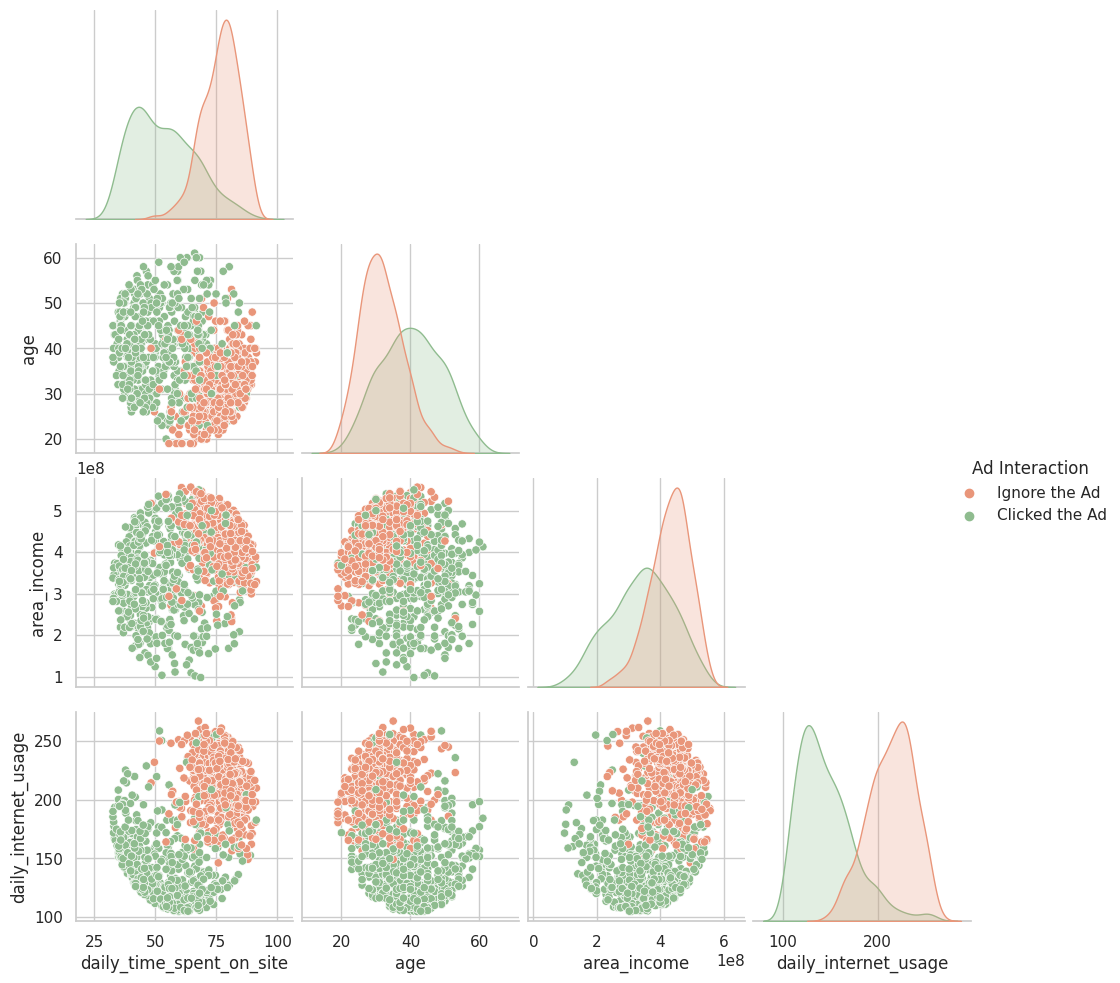

In [ ]:
# Pair plot the selected features
plt.figure(figsize=(12, 10))

color_palette = ['#E9967A', '#8FBC8F']
hue_order = [0, 1]

# Create a pairplot
plot = sns.pairplot(df_clean[selected_feat], hue='clicked_on_ad', palette=color_palette, hue_order=hue_order, corner=True)

# Customize the default legend
plot._legend.set_title('Ad Interaction')

# Customize the default legend
new_labels = ['Ignore the Ad', 'Clicked the Ad']
for t, l in zip(plot._legend.texts, new_labels): t.set_text(l)

plt.show()

The scatter plot analysis unveils distinctive customer behaviors, encompassing:

* Active users, characterized by extended time spent on the site and high daily internet usage, tend to refrain from clicking on ads.
* Conversely, non-active users, marked by shorter site visits and lower daily internet usage, show a propensity to click on ads.
* Individuals boasting high area income, prolonged daily time spent on the site, and elevated daily internet usage exhibit a tendency to abstain from clicking on ads.
* Those under 40 years of age, despite engaging in significant daily internet usage and prolonged site visits, demonstrate a tendency to avoid clicking on ads.




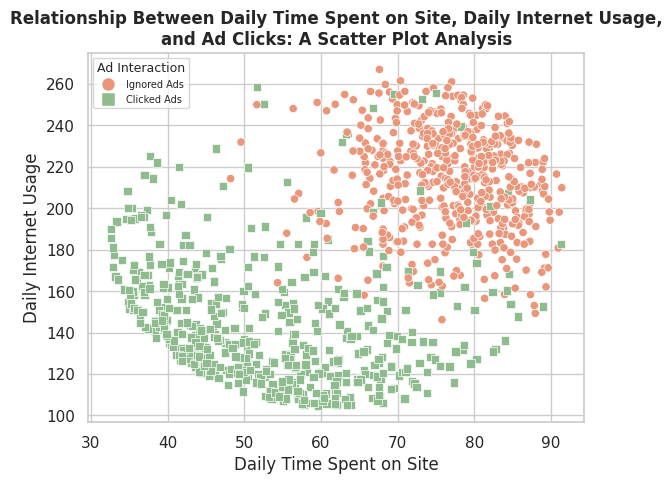

In [ ]:
from matplotlib.lines import Line2D

# Create a scatter plot
scatter_plot = sns.scatterplot(data=df_clean[selected_feat], x='daily_time_spent_on_site', y='daily_internet_usage', hue='clicked_on_ad',
                               palette=['#E9967A', '#8FBC8F'], style='clicked_on_ad', markers=['o', 's'])

# Create a custom legend with colored labels
legend_labels = ['Ignored Ads', 'Clicked Ads']
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='#E9967A', markersize=10, label=legend_labels[0]),
                   Line2D([0], [0], marker='s', color='w', markerfacecolor='#8FBC8F', markersize=10, label=legend_labels[1])]

plt.legend(handles=legend_elements, title='Ad Interaction', title_fontsize=9, fontsize=7)

# Set plot title and labels
plt.title('Relationship Between Daily Time Spent on Site, Daily Internet Usage,\nand Ad Clicks: A Scatter Plot Analysis',
          weight='bold')
plt.xlabel('Daily Time Spent on Site')
plt.ylabel('Daily Internet Usage')

plt.show()

Let's see what the younger group of people interested of seeing.

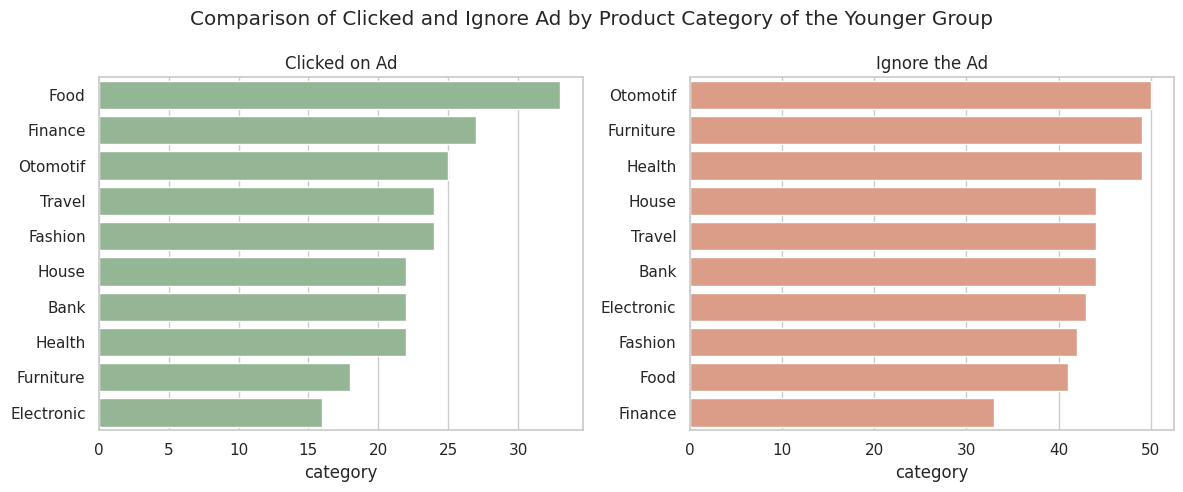

In [ ]:
clicked_young = yes[yes['age'] < 40]
ignored_young = no[no['age'] < 40]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=clicked_young['category'].value_counts(), y=clicked_young['category'].value_counts().index, ax=axs[0], color="#8FBC8F")
axs[0].set_title('Clicked on Ad')

sns.barplot(x=ignored_young['category'].value_counts(), y=ignored_young['category'].value_counts().index, ax=axs[1], color="#E9967A")
axs[1].set_title('Ignore the Ad')

plt.suptitle('Comparison of Clicked and Ignore Ad by Product Category of the Younger Group')
plt.tight_layout()
plt.show()

# **3. Data Preprocessing**

## Feature Selection

In [ ]:
# Drop other features that does not have a correlation with the target
selected_feat = ['daily_time_spent_on_site', 'age', 'area_income',
                     'daily_internet_usage', 'clicked_on_ad']

df_corred = df_clean[selected_feat]

df_corred.sample(3)

,daily_time_spent_on_site,age,area_income,daily_internet_usage,clicked_on_ad
468,65.59,47,197860670.0,121.81,1
749,54.35,42,538889470.0,164.02,0
583,68.60,33,479142580.0,135.08,1


All the features are numerical so we can skip feature encoding and do data splitting.

## Split Data

We split the data to 70% train, 15% test, and 15% validation.

In [ ]:
# Define features and target variable
X = df_corred.drop('clicked_on_ad', axis=1)
y = df_corred['clicked_on_ad']

In [ ]:
# Split the data into a training set and a temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split the temporary set into a validation set and a test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print('Shape of train:', '\n', 'X_train', X_train.shape, 'y_train', y_train.shape)
print('Shape of validation:', '\n', 'X_val', X_val.shape, 'y_val', y_val.shape)
print('Shape of test:', '\n', 'X_test', X_test.shape, 'y_test', y_test.shape)

Shape of train: 
 X_train (697, 4) y_train (697,)
Shape of validation: 
 X_val (150, 4) y_val (150,)
Shape of test: 
 X_test (150, 4) y_test (150,)


In [ ]:
print(f"y_train:\n{y_train.value_counts()}")
print(f"y_test:\n{y_test.value_counts()}")
print(f"y_val:\n{y_val.value_counts()}")

y_train:
1    349
0    348
Name: clicked_on_ad, dtype: int64
y_test:
0    75
1    75
Name: clicked_on_ad, dtype: int64
y_val:
0    75
1    75
Name: clicked_on_ad, dtype: int64


## Data Normalization

In [ ]:
# Define scaler used
scaler = MinMaxScaler()

# Normalize the train data
X_train_norm = scaler.fit_transform(X_train)

X_train = pd.DataFrame(X_train_norm, columns=X_train.columns)

X_train.sample(3)

,daily_time_spent_on_site,age,area_income,daily_internet_usage
645,0.301377,0.738095,0.739956,0.175183
76,0.964474,0.309524,0.547688,0.449978
447,0.068332,0.309524,0.561657,0.355421


In [ ]:
# Normalize the test data
X_test_norm = scaler.fit_transform(X_test)

X_test = pd.DataFrame(X_test_norm, columns=X_test.columns)

X_test.sample(3)

,daily_time_spent_on_site,age,area_income,daily_internet_usage
143,0.095591,0.594595,0.673543,0.271440
5,0.478643,0.783784,0.439079,0.036032
95,0.047193,0.540541,0.258052,0.448278


In [ ]:
# Normalize the validation data
X_val_norm = scaler.fit_transform(X_val)

X_val = pd.DataFrame(X_val_norm, columns=X_val.columns)

X_val.sample(3)

,daily_time_spent_on_site,age,area_income,daily_internet_usage
111,0.243210,0.925,0.565598,0.290552
115,0.649559,0.300,0.942034,0.514485
82,0.778483,0.375,0.904061,0.406238


# **Machine Learning Modelling**

## Model Selection

In [ ]:
# Define the Classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(random_state=42),
}

# Store the evaluation metrics in a table
results = {
    "Model": [],
    "Train Accuracy": [],
    "Validation Accuracy": [],
    "Train ROC AUC": [],
    "Validation ROC AUC": [],
    "Train Log Loss": [],
    "Validation Log Loss": []
}

# Define the parameters for K-Fold Cross Validation
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop through classifiers and evaluate performance
for model_name, model in classifiers.items():
    accuracy_train_scores = []
    accuracy_validation_scores = []
    roc_auc_train_scores = []
    roc_auc_validation_scores = []
    logloss_train_scores = []
    logloss_validation_scores = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_train_fold = model.predict(X_train_fold)
        y_pred_probabilities_train_fold = model.predict_proba(X_train_fold)

        y_pred_test_fold = model.predict(X_test_fold)
        y_pred_probabilities_test_fold = model.predict_proba(X_test_fold)

        accuracy_train = accuracy_score(y_train_fold, y_pred_train_fold)
        accuracy_validation = accuracy_score(y_test_fold, y_pred_test_fold)
        roc_auc_train = roc_auc_score(y_train_fold, y_pred_probabilities_train_fold[:, 1])
        roc_auc_validation = roc_auc_score(y_test_fold, y_pred_probabilities_test_fold[:, 1])
        logloss_train = log_loss(y_train_fold, y_pred_probabilities_train_fold)
        logloss_validation = log_loss(y_test_fold, y_pred_probabilities_test_fold)

        accuracy_train_scores.append(accuracy_train)
        accuracy_validation_scores.append(accuracy_validation)
        roc_auc_train_scores.append(roc_auc_train)
        roc_auc_validation_scores.append(roc_auc_validation)
        logloss_train_scores.append(logloss_train)
        logloss_validation_scores.append(logloss_validation)

    # Calculate the mean of the performance metrics across folds
    mean_accuracy_train = np.mean(accuracy_train_scores)
    mean_accuracy_validation = np.mean(accuracy_validation_scores)
    mean_roc_auc_train = np.mean(roc_auc_train_scores)
    mean_roc_auc_validation = np.mean(roc_auc_validation_scores)
    mean_logloss_train = np.mean(logloss_train_scores)
    mean_logloss_validation = np.mean(logloss_validation_scores)

    results["Model"].append(model_name)
    results["Train Accuracy"].append(mean_accuracy_train)
    results["Validation Accuracy"].append(mean_accuracy_validation)
    results["Train ROC AUC"].append(mean_roc_auc_train)
    results["Validation ROC AUC"].append(mean_roc_auc_validation)
    results["Train Log Loss"].append(mean_logloss_train)
    results["Validation Log Loss"].append(mean_logloss_validation)

    print(f"Model: {model_name} Training and Validation finished.")

results_df = pd.DataFrame(results)

Model: Decision Tree Training and Validation finished.
Model: Random Forest Training and Validation finished.
Model: XGBoost Training and Validation finished.
Model: Gradient Boosting Training and Validation finished.
Model: KNN Training and Validation finished.
Model: Naive Bayes Training and Validation finished.
Model: Logistic Regression Training and Validation finished.


In [ ]:
results_df

,Model,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train Log Loss,Validation Log Loss
0,Decision Tree,1.000000,0.929681,1.000000,0.929187,2.220446e-16,2.534539
1,Random Forest,1.000000,0.959836,1.000000,0.989062,2.802384e-02,0.207091
2,XGBoost,1.000000,0.955529,1.000000,0.989830,1.064417e-02,0.139579
3,Gradient Boosting,1.000000,0.956968,1.000000,0.988096,1.348202e-02,0.139139
4,KNN,0.966645,0.961285,0.997066,0.983019,6.604617e-02,0.525476
5,Naive Bayes,0.969154,0.965570,0.989852,0.988802,1.066777e-01,0.108869
6,Logistic Regression,0.964490,0.962682,0.989906,0.988920,1.433345e-01,0.146088


Considering overfitting metrics, encompassing train and validation accuracy, ROC AUC scores, and log loss, the standout models in this context are Naive Bayes, Logistic Regression, and Random Forest.

### Learning Curve

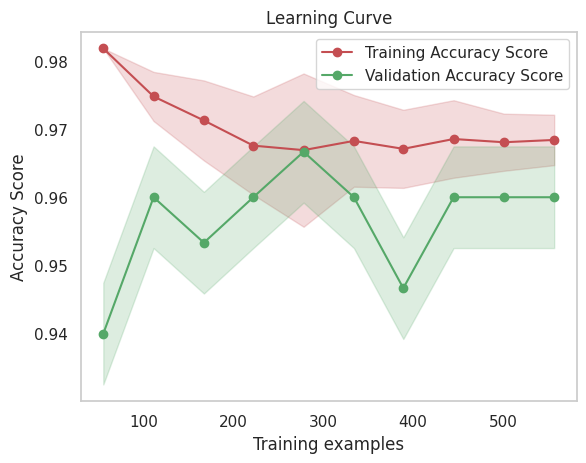

In [ ]:
# Gaussian Naive Bayes Model

nb_model = GaussianNB()

# Compute the learning curve using the training data
train_sizes, train_scores, _ = learning_curve(
    nb_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation accuracy score at each training set size
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# Evaluate the model on the validation data
val_scores = [accuracy_score(y_val, nb_model.fit(X_train[:int(size * len(X_train))], y_train[:int(size * len(X_train))]).predict(X_val)) for size in np.linspace(0.1, 1.0, 10)]

# Calculate the validation standard deviation accuracy score
val_scores_std = np.std(val_scores)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(train_sizes, val_scores, 'o-', color="g", label="Validation Accuracy Score")
plt.fill_between(train_sizes, val_scores - val_scores_std, val_scores + val_scores_std, alpha=0.2, color="g")

plt.legend(loc="best")
plt.show()

Given the inherent simplicity of Naive Bayes, the basic version of Naive Bayes does not allow direct tuning. As the performance of the Naive Bayes model falls short, we will not use this model and continue to tune the other two model.



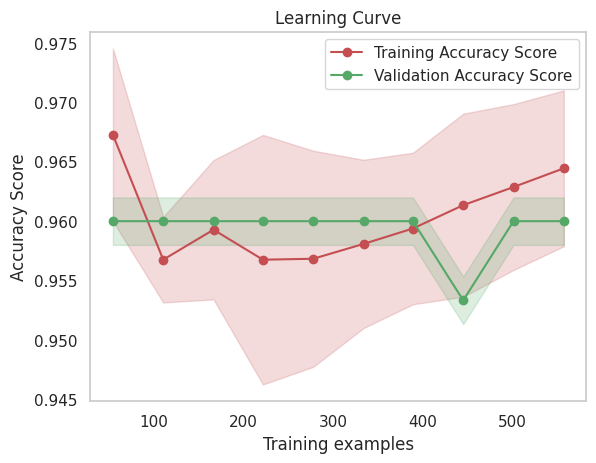

In [ ]:
# Logistic Regression Model

lr_model = LogisticRegression(random_state=42)

# Compute the learning curve using the training data
train_sizes, train_scores, _ = learning_curve(
    lr_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation accuracy score at each training set size
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# Evaluate the model on the validation data
val_scores = [accuracy_score(y_val, lr_model.fit(X_train[:int(size * len(X_train))], y_train[:int(size * len(X_train))]).predict(X_val)) for size in np.linspace(0.1, 1.0, 10)]

# Calculate the validation standard deviation accuracy score
val_scores_std = np.std(val_scores)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(train_sizes, val_scores, 'o-', color="g", label="Validation Accuracy Score")
plt.fill_between(train_sizes, val_scores - val_scores_std, val_scores + val_scores_std, alpha=0.2, color="g")

plt.legend(loc="best")
plt.show()

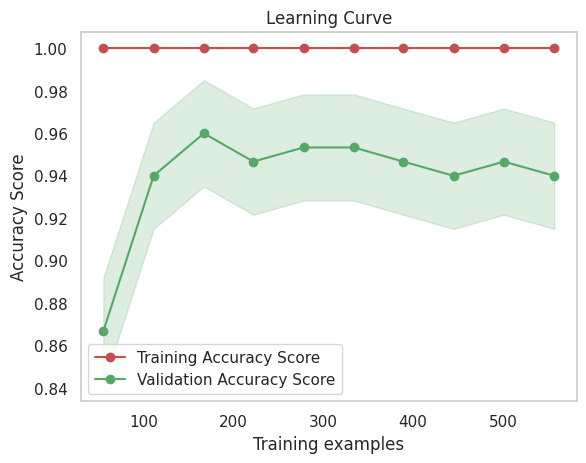

In [ ]:
# Random Forest Model

rf_model = RandomForestClassifier(random_state=42)

# Compute the learning curve using the training data
train_sizes, train_scores, _ = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation accuracy score at each training set size
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# Evaluate the model on the validation data
val_scores = [accuracy_score(y_val, rf_model.fit(X_train[:int(size * len(X_train))], y_train[:int(size * len(X_train))]).predict(X_val)) for size in np.linspace(0.1, 1.0, 10)]

# Calculate the validation standard deviation accuracy score
val_scores_std = np.std(val_scores)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(train_sizes, val_scores, 'o-', color="g", label="Validation Accuracy Score")
plt.fill_between(train_sizes, val_scores - val_scores_std, val_scores + val_scores_std, alpha=0.2, color="g")

plt.legend(loc="best")
plt.show()

All three of the models that are SVM, Logistic Regression, and Random Forest need hyperparameter tuning.

## Hyperparameter Tuning

### Logistic Regression

In [ ]:
# # Set a random seed for reproducibility
# random.seed(42)
# np.random.seed(42)

# # Define your objective function to optimize
# def objective(trial):
#     # Define the search space for Logistic Regression hyperparameters
#     params = {
#         'C': trial.suggest_loguniform('C', 1, 5),
#         'penalty': trial.suggest_categorical('penalty', ['l1']),
#         'solver': trial.suggest_categorical('solver', ['saga']),
#     }

#     # Create the Logistic Regression model with the sampled hyperparameters
#     model = LogisticRegression(**params)

#     # Perform k-fold cross-validation and calculate accuracy
#     accuracy_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

#     # Calculate the mean accuracy as the metric to optimize
#     accuracy = accuracy_scores.mean()

#     return accuracy

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')  # Maximizing accuracy

# # Run the optimization
# study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# # Create the best model using the best hyperparameters
# best_model = LogisticRegression(random_state=42, **best_params)

# # Train the final model on the entire training dataset
# best_model.fit(X_train, y_train)

# # Make predictions on the validation set using the best model
# y_pred = best_model.predict(X_val)

# # Calculate the accuracy using the best model
# best_accuracy = accuracy_score(y_val, y_pred)
# print("Accuracy with Best Hyperparameters:", best_accuracy)

[I 2023-11-14 22:52:46,818] A new study created in memory with name: no-name-8138c923-b9ab-47be-ae9c-493de097bc20
[I 2023-11-14 22:52:46,908] Trial 0 finished with value: 0.9669886947584789 and parameters: {'C': 1.9683599061516228, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 0 with value: 0.9669886947584789.
[I 2023-11-14 22:52:47,014] Trial 1 finished with value: 0.9655498458376156 and parameters: {'C': 3.2906623064640352, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 0 with value: 0.9669886947584789.
[I 2023-11-14 22:52:47,099] Trial 2 finished with value: 0.9655498458376156 and parameters: {'C': 2.755637029613682, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 0 with value: 0.9669886947584789.
[I 2023-11-14 22:52:47,186] Trial 3 finished with value: 0.9655498458376156 and parameters: {'C': 3.382928824673104, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 0 with value: 0.9669886947584789.
[I 2023-11-14 22:52:47,280] Trial 4 finished with value: 0.9655498458376156 and 

Best Hyperparameters: {'C': 1.9683599061516228, 'penalty': 'l1', 'solver': 'saga'}
Accuracy with Best Hyperparameters: 0.96


#### Logistic Regression Best Parameters

Best Hyperparameters:
* 'C': 1.9683599061516228
* 'penalty': 'l1'
* 'solver': 'saga'

Train Accuracy Score: 0.9669886947584789

Validation Accuracy Score: 0.96

In [ ]:
# Define the hyperparameters for the Logistic Regression
lr_params = {'C': 1.9683599061516228, 'penalty': 'l1', 'solver': 'saga'}

# Create the Logistic Regression classifier with the specified hyperparameters
lr_model = LogisticRegression(random_state=42, **lr_params)

#### Learning Curve

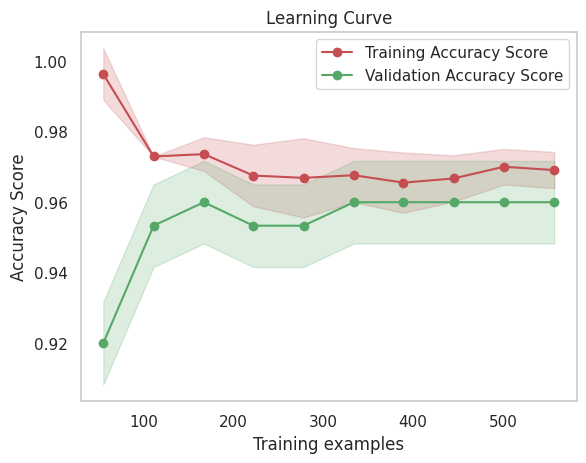

In [ ]:
# # Compute the learning curve using the training data
# train_sizes, train_scores, _ = learning_curve(
#     lr_model, X_train, y_train, cv=5, scoring='accuracy',
#     train_sizes=np.linspace(0.1, 1.0, 10)
# )

# # Calculate the mean and standard deviation accuracy score at each training set size
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)

# # Evaluate the model on the validation data
# val_scores = [accuracy_score(y_val, lr_model.fit(X_train[:int(size * len(X_train))], y_train[:int(size * len(X_train))]).predict(X_val)) for size in np.linspace(0.1, 1.0, 10)]

# # Calculate the validation standard deviation accuracy score
# val_scores_std = np.std(val_scores)

# # Plot the learning curve
# plt.figure()
# plt.title("Learning Curve")
# plt.xlabel("Training examples")
# plt.ylabel("Accuracy Score")
# plt.grid()

# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy Score")
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
# plt.plot(train_sizes, val_scores, 'o-', color="g", label="Validation Accuracy Score")
# plt.fill_between(train_sizes, val_scores - val_scores_std, val_scores + val_scores_std, alpha=0.2, color="g")

# plt.legend(loc="best")
# plt.show()

#### Bias Variance Trade-off Decomp

In [ ]:
from mlxtend.evaluate import bias_variance_decomp

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        lr_model, X_train.values, y_train.values, X_val.values, y_val.values,
        loss='0-1_loss',
        random_seed=42)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.038
Average bias: 0.040
Average variance: 0.004


#### Log Loss

In [ ]:
# Fitting the model
lr_model.fit(X_train, y_train)

# Predict probabilities for each class
pred_prob_lr = lr_model.predict_proba(X_val)[:, 1]

# Calculate log loss for Logistic Regression
log_loss_lr = log_loss(y_val, pred_prob_lr)

print('Validation Log Loss:', log_loss_lr)

Validation Log Loss: 0.0882606410757982


### Random Forest

In [ ]:
# # Set a random seed for reproducibility
# random.seed(42)
# np.random.seed(42)

# # Define your objective function to optimize
# def objective(trial):
#     # Define the search space for Random Forest hyperparameters
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 150),
#         'max_depth': trial.suggest_int('max_depth', 5, 20),
#         'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 0.8),
#     }

#     # Create the Random Forest model with the sampled hyperparameters
#     model = RandomForestClassifier(**params)

#     # Perform k-fold cross-validation and calculate accuracy
#     accuracy_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

#     # Calculate the mean accuracy as the metric to optimize
#     accuracy = accuracy_scores.mean()

#     return accuracy

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')  # Maximizing accuracy

# # Run the optimization
# study.optimize(objective, n_trials=300)  # You can adjust the number of trials

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# # Create the best model using the best hyperparameters
# best_model = RandomForestClassifier(random_state=42, **best_params)

# # Train the final model on the entire training dataset
# best_model.fit(X_train, y_train)

# # Make predictions on the validation set using the best model
# y_pred = best_model.predict(X_val)

# # Calculate the accuracy using the best model
# best_accuracy = accuracy_score(y_val, y_pred)
# print("Accuracy with Best Hyperparameters:", best_accuracy)

[I 2023-11-14 23:31:03,343] A new study created in memory with name: no-name-03373fb0-099f-4db6-bfbc-3817848a4dff
[I 2023-11-14 23:31:04,371] Trial 0 finished with value: 0.9569373072970195 and parameters: {'n_estimators': 103, 'max_depth': 7, 'min_samples_split': 0.26341007644739206}. Best is trial 0 with value: 0.9569373072970195.
[I 2023-11-14 23:31:05,502] Trial 1 finished with value: 0.9197019527235355 and parameters: {'n_estimators': 129, 'max_depth': 6, 'min_samples_split': 0.4930920639911327}. Best is trial 0 with value: 0.9569373072970195.
[I 2023-11-14 23:31:06,400] Trial 2 finished with value: 0.958365878725591 and parameters: {'n_estimators': 88, 'max_depth': 15, 'min_samples_split': 0.17706416546510068}. Best is trial 2 with value: 0.958365878725591.
[I 2023-11-14 23:31:07,171] Trial 3 finished with value: 0.958365878725591 and parameters: {'n_estimators': 77, 'max_depth': 5, 'min_samples_split': 0.2913480208760706}. Best is trial 2 with value: 0.958365878725591.
[I 2023-1

Best Hyperparameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 0.1369903796276633}
Accuracy with Best Hyperparameters: 0.94


#### Random Forest Best Parameters

Best Hyperparameters:
* 'n_estimators': 131
* 'max_depth': 6
* 'min_samples_split': 0.1369903796276633

Train Accuracy Score: 0.9684275436793423

Validation Accuracy Score: 0.94

In [ ]:
# Define the hyperparameters for the Logistic Regression
rf_params = {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 0.1369903796276633}

# Create the Logistic Regression classifier with the specified hyperparameters
rf_model = RandomForestClassifier(random_state=42, **rf_params)

#### Learning Curve

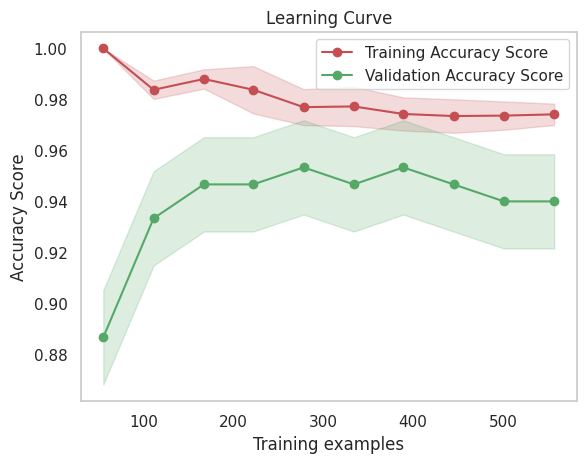

In [ ]:
# # Compute the learning curve using the training data
# train_sizes, train_scores, _ = learning_curve(
#     rf_model, X_train, y_train, cv=5, scoring='accuracy',
#     train_sizes=np.linspace(0.1, 1.0, 10)
# )

# # Calculate the mean and standard deviation accuracy score at each training set size
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)

# # Evaluate the model on the validation data
# val_scores = [accuracy_score(y_val, rf_model.fit(X_train[:int(size * len(X_train))], y_train[:int(size * len(X_train))]).predict(X_val)) for size in np.linspace(0.1, 1.0, 10)]

# # Calculate the validation standard deviation accuracy score
# val_scores_std = np.std(val_scores)

# # Plot the learning curve
# plt.figure()
# plt.title("Learning Curve")
# plt.xlabel("Training examples")
# plt.ylabel("Accuracy Score")
# plt.grid()

# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy Score")
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
# plt.plot(train_sizes, val_scores, 'o-', color="g", label="Validation Accuracy Score")
# plt.fill_between(train_sizes, val_scores - val_scores_std, val_scores + val_scores_std, alpha=0.2, color="g")

# plt.legend(loc="best")
# plt.show()

#### Bias Variance Trade-off Decomp

In [ ]:
from mlxtend.evaluate import bias_variance_decomp

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        rf_model, X_train.values, y_train.values, X_val.values, y_val.values,
        loss='0-1_loss',
        random_seed=42)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.057
Average bias: 0.053
Average variance: 0.018


#### Log Loss

In [ ]:
# Fitting the model
rf_model.fit(X_train, y_train)

# Predict probabilities for each class
pred_prob_rf = rf_model.predict_proba(X_val)[:, 1]

# Calculate log loss for Random Forest
log_loss_rf = log_loss(y_val, pred_prob_rf)

print('Validation Log Loss:', log_loss_rf)

Validation Log Loss: 0.1511541420879668


Based on a comprehensive assessment of the learning curve, bias-variance trade-off decomposition, and log loss, it is evident that the Logistic Regression model exhibits superior performance. Consequently, we have decided to select this model for further evaluation.

## Model Evaluation

In [ ]:
# Combining train and validation data
X_train_and_val = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_and_val = pd.concat([y_train, y_val], ignore_index=True)

In [ ]:
y_train_and_val.value_counts()

1    424
0    423
Name: clicked_on_ad, dtype: int64

### Model Fitting

In [ ]:
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc
from sklearn.model_selection import cross_val_predict

# Set random seeds for reproducibility
np.random.seed(42)
random_state = 42

# Logistic Regression models with best hyperparameters
lr_model = LogisticRegression(random_state=random_state, **lr_params)

# Predict probabilities using cross-validation on the combined train and validation set for Logistic Regression
pred_prob_train_val_cv_lr = cross_val_predict(lr_model, X_train_and_val, y_train_and_val, method='predict_proba', cv=5)

# Compute log loss for the combined train and validation set for Logistic Regression
log_loss_train_val_cv_lr = log_loss(y_train_and_val, pred_prob_train_val_cv_lr)

# Fit the Logistic Regression model on the entire combined train and validation set
lr_model.fit(X_train_and_val, y_train_and_val)

# Predict probabilities on the test set for Logistic Regression
pred_prob_lr = lr_model.predict_proba(X_test)

# Compute ROC curve and AUC for Logistic Regression on the test set
fpr_lr, tpr_lr, _ = roc_curve(y_test, pred_prob_lr[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Calculate test accuracy for Logistic Regression
predicted_labels_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, predicted_labels_lr)

# Calculate log loss for Logistic Regression on the test set
log_loss_lr = log_loss(y_test, pred_prob_lr)

print(f"Logistic Regression Combined Train+Val Log Loss (CV): {log_loss_train_val_cv_lr:.4f}")
print(f"Logistic Regression Test Accuracy: {accuracy_lr:.4f}")
print(f"Logistic Regression Test Log Loss: {log_loss_lr:.4f}")

Logistic Regression Combined Train+Val Log Loss (CV): 0.1011
Logistic Regression Test Accuracy: 0.9800
Logistic Regression Test Log Loss: 0.1033


### Area Under ROC Curve

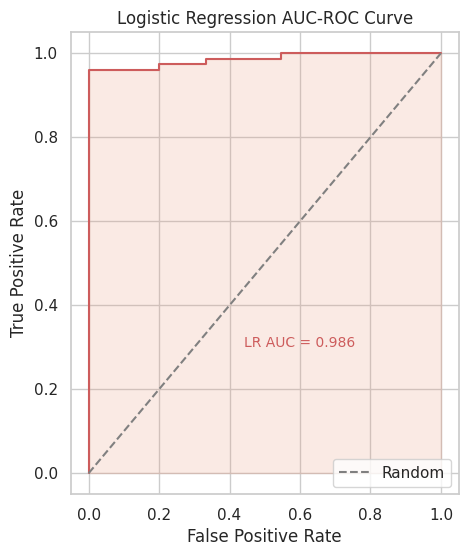

In [ ]:
# Plot SVM ROC curve
plt.figure(figsize=(5, 6))  # Adjust the figure size as needed

# Plot Logistic Regression ROC curve
plt.plot(fpr_lr, tpr_lr, color='#CD5C5C')
plt.fill_between(fpr_lr, tpr_lr, alpha=0.2, color='#E9967A')

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Annotate the AUC scores inside the plot
plt.annotate(f'LR AUC = {roc_auc_lr:.3f}', xy=(0.6, 0.1), xytext=(0.6, 0.3),
             fontsize=10, color='#CD5C5C', ha='center')

# Set labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression AUC-ROC Curve')
plt.legend()
plt.show()

### Confusion Matrix

Hyperparameters: {'C': 1.9683599061516228, 'penalty': 'l1', 'solver': 'saga'}
Accuracy (Training and Validation): 0.9633971458405849
Accuracy (Test): 0.98
ROC AUC Score (Training and Validation): 0.9908581314878893
ROC AUC Score (Test): 0.9856
Log Loss (Training and Validation): 0.10107883225979272
Log Loss (Test): 0.10326898813631841


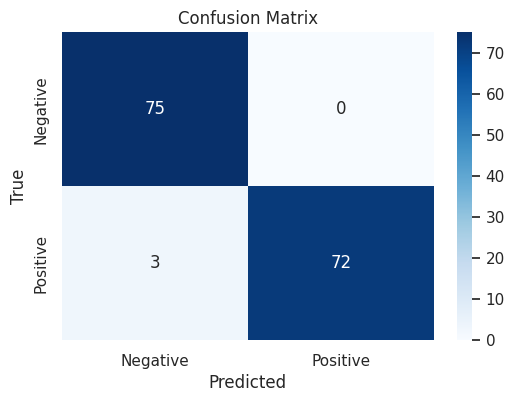

In [ ]:
# Set a random seed for reproducibility
np.random.seed(42)
random_state = 42

# Predictions on the training and validation set
y_train_and_val_pred = lr_model.predict(X_train_and_val)
y_train_and_val_probabilities = lr_model.predict_proba(X_train_and_val)

# Make predictions on your test data
y_test_pred = lr_model.predict(X_test)
y_test_probabilities = lr_model.predict_proba(X_test)

# Calculate accuracy for training and validation set using 5-fold cross-validation
accuracy_train_and_val = cross_val_score(lr_model, X_train_and_val, y_train_and_val, cv=5, scoring='accuracy').mean()

# Calculate ROC AUC score for training and validation set using 5-fold cross-validation
roc_auc_train_and_val = cross_val_score(lr_model, X_train_and_val, y_train_and_val, cv=5, scoring='roc_auc').mean()

# Calculate log loss for training and validation set using 5-fold cross-validation
log_loss_train_and_val = -cross_val_score(lr_model, X_train_and_val, y_train_and_val, cv=5, scoring='neg_log_loss').mean()

# Calculate accuracy for the test set
accuracy_test = accuracy_score(y_test, y_test_pred)

# Calculate ROC AUC score for the test set
roc_auc_test = roc_auc_score(y_test, y_test_probabilities[:, 1])

# Calculate log loss for the test set
log_loss_test = log_loss(y_test, y_test_probabilities)

# Print the results
print("Hyperparameters:", lr_params)
print("Accuracy (Training and Validation):", accuracy_train_and_val)
print("Accuracy (Test):", accuracy_test)
print("ROC AUC Score (Training and Validation):", roc_auc_train_and_val)
print("ROC AUC Score (Test):", roc_auc_test)
print("Log Loss (Training and Validation):", log_loss_train_and_val)
print("Log Loss (Test):", log_loss_test)

# Generate the confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix for visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Both models exhibit impressive performance, yielding results that are subtly distinct. Consequently, I have decided to proceed and select the Logistic Regression model.

### Feature Importance

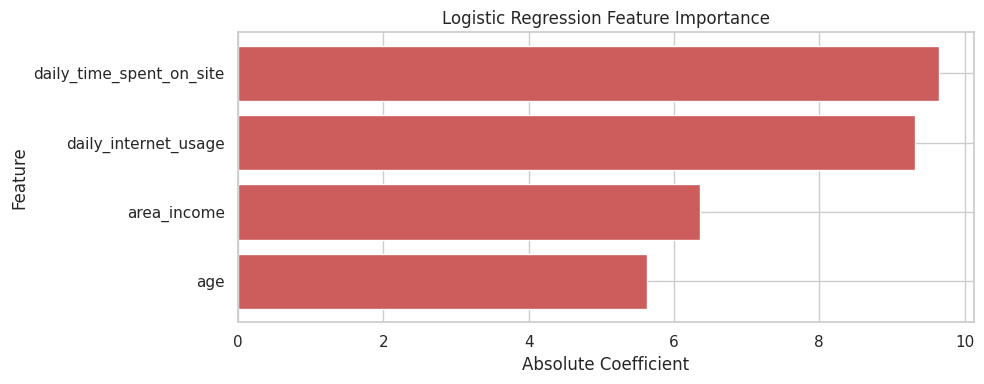

In [ ]:
# Get feature coefficients and names
feature_coeffs = np.abs(lr_model.coef_[0])
feature_names = X_train_and_val.columns

# Sort features by their absolute coefficients
sorted_indices = np.argsort(feature_coeffs)[::1]
sorted_coeffs = feature_coeffs[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 4))
plt.barh(range(len(feature_coeffs)), sorted_coeffs, tick_label=sorted_feature_names, color='#CD5C5C')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance')
plt.tight_layout()
plt.show()

### SHAP Values



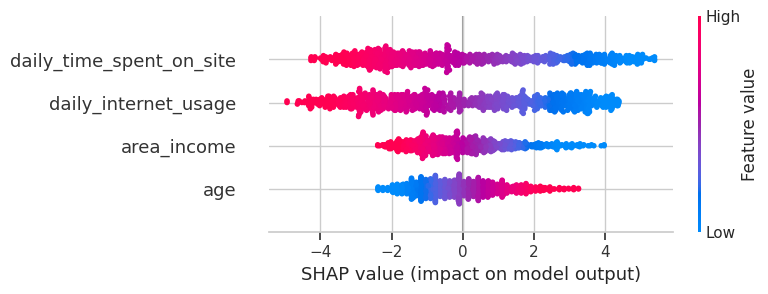

In [ ]:
# Create a Shapley explainer for the logistic regression model
explainer = shap.LinearExplainer(lr_model, X_train_and_val)

# Get Shapley values
shap_values = explainer.shap_values(X_train_and_val.iloc[:1000, :])

# Plot summary plot
shap.summary_plot(shap_values, X_train_and_val.iloc[:1000, :], feature_names=X_train_and_val.columns)

**Daily Time Spent on Site:**

More extreme values in daily time spent on the site, either very high or very low, correlate with an increased likelihood of clicking the ad. The wider bands emphasize the significant impact of this feature on ad-click behavior.

**Daily Internet Usage:**

Similar to time spent on the site, extremes in daily internet usage (high or low) are associated with a higher probability of ad clicking. The broad bands highlight the substantial influence of this variable on the target.

**Area Income:**

Higher area income values are linked to a decreased likelihood of ad clicking, emphasizing that wealthier areas tend to click less. The distinct separation in bands underscores the importance of area income in predicting ad-click behavior.

**Age:**

Higher age values are associated with an increased likelihood of clicking the ad. The distinct bands suggest that older individuals are more likely to click, highlighting the predictive value of age in ad-click behavior.

In [ ]:
y_test

372    0
970    1
85     1
876    1
808    1
      ..
612    0
447    0
4      0
526    1
806    1
Name: clicked_on_ad, Length: 150, dtype: int64

# Business Simulation

In [ ]:
clicked = len(y_test[y_test == 1])
ignored = len(y_test[y_test == 0])

print(f"Clicked Total: {clicked}")
print(f"Ignored Total: {ignored}")

Clicked Total: 75
Ignored Total: 75


In [ ]:
# Cost of advertise per person
cost = 10000

# Revenue when the individual clicks on the ad
revenue = 13000

# Extract True Positive and False Positive from Confusion Matrix
tp = conf_matrix[1][1]
fp = conf_matrix[0][1]

# Without Model
# Click-Through Rate
without_ctr = (clicked / (clicked + ignored)) * 100

# Net Profit per Click
without_cost = cost * (clicked + ignored)
without_revenue = revenue * clicked
without_npc = without_revenue - without_cost

# With Model
# Click-Through Rate
with_ctr = (tp / (tp + fp)) * 100

# Net Profit per Click
with_cost = cost * (tp + fp)
with_revenue = revenue * tp
with_npc = with_revenue - with_cost

print('Without Model:\nClick-Through Rate:', without_ctr, '%\nNet Profit per Click:', without_npc)
print('With Model:\nClick-Through Rate:', with_ctr, '%\nNet Profit per Click:', with_npc)

Without Model:
Click-Through Rate: 50.0 %
Net Profit per Click: -525000
With Model:
Click-Through Rate: 100.0 %
Net Profit per Click: 216000
